# Wood-Ljungdahl Training

Summary analysis of training runs of 7/2023 in which I tried to teach the cells the Wood-Ljungdahl pathway in multiple stages of batch culture.
In follow-up experiment, in 10/2023, I wanted to reduce their genome and proteome sizes.

Below is a summary of all runs in this directory.
First, there was a short batch culture to get cells which can grow in the starting medium (`init-cells`).
Then, there was a cascade of batch cultures that successively try to add parts of WL to the cells (`train-pathway`).
Finally, there was a Chemostat culture which tested whether the final celllines were able to grow in the final medium alone (`validate-cells`).

Some months after that I used batch cultures again to reduce the genome sizes of the resulting cells of the previous validation runs (`shrink-genomes`).
Then again, in a ChemoStat I checked whether the cells can still grow on CO2 and E alone (`validate-cells`).

In [1]:
import json
from pathlib import Path
from collections import Counter
import numpy as np
import pandas as pd
from tensorboard.backend.event_processing import event_accumulator
from plotnine import *
from sklearn.cluster import DBSCAN
import magicsoup as ms
import e1_co2_fixing.src.util as util

theme_set(theme_minimal())
THIS_DIR = Path(".") / "e1_co2_fixing"
RUNS_DIR = THIS_DIR / "runs"

world = ms.World.from_file(rundir=RUNS_DIR)

In [2]:
def load_hparams(glob: str) -> pd.DataFrame:
    records = []
    for rundir in RUNS_DIR.glob(glob):
        with open(rundir / "hparams.json", "r") as fh:
            data = json.load(fh)
        records.append({"name": rundir.name, **data})

    df = pd.DataFrame.from_records(records)
    df.loc[:, "trial"] = "n" + df["name"].str.rsplit("_", n=1).str[1]
    df.loc[:, "purpose"] = "validate-cells"
    df.loc[df["name"] == "2023-07-22_11-51_0", "purpose"] = "init-cells"
    df.loc[~df["pathway-label"].isna(), "purpose"] = "train-pathway"
    df.loc[~df["to_k"].isna(), "purpose"] = "shrink-genomes"
    df.loc[:, "culture"] = "batch"
    df.loc[df["purpose"] == "validate-cells", "culture"] = "chemostat"
    return df.sort_values("name").reset_index()

hparams = load_hparams("2023-*")
hparams[["name", "trial", "pathway-label", "init-label", "purpose", "culture"]]

,name,trial,pathway-label,init-label,purpose,culture
0,2023-07-22_11-51_0,n0,NaN,NaN,init-cells,batch
1,2023-07-22_11-56_0,n0,WL-0,2023-07-22_11-51_0:-1,train-pathway,batch
2,2023-07-22_11-56_1,n1,WL-0,2023-07-22_11-51_0:-1,train-pathway,batch
3,2023-07-22_12-19_0,n0,WL-1,2023-07-22_11-56_0:-1,train-pathway,batch
4,2023-07-22_12-19_1,n1,WL-1,2023-07-22_11-56_0:-1,train-pathway,batch
5,2023-07-22_12-44_0,n0,WL-2,2023-07-22_12-19_0:-1,train-pathway,batch
6,2023-07-22_12-44_1,n1,WL-2,2023-07-22_12-19_0:-1,train-pathway,batch
7,2023-07-22_14-14_0,n0,WL-3,2023-07-22_12-44_0:-1,train-pathway,batch
8,2023-07-22_14-14_1,n1,WL-3,2023-07-22_12-44_0:-1,train-pathway,batch
9,2023-07-23_13-37_0,n0,WL-4,2023-07-22_14-14_0:-1,train-pathway,batch


## Init Cells

asd

In [17]:
def sample_steps(steps: list[int], n: int) -> list[int]:
    if n > len(steps):
        return steps
    d, r = divmod(len(steps), n)
    out = [steps[i * d] for i in range(n)]
    return out + [steps[-1]] if r > 0 else out

def get_run_overview(world: ms.World, name: str, molecules: list[str], n_parts=6) -> pd.DataFrame:
    records = []
    for _, row in hparams.loc[hparams["name"] == name].iterrows():
        rundir = RUNS_DIR / row["name"]
        all_steps = util.find_steps(rundir=rundir)
        
        for step in sample_steps(steps=all_steps, n=n_parts):
            world.load_state(statedir=RUNS_DIR / row["name"] / f"step={step}", ignore_cell_params=True)
            xs = world.cell_positions[:, 0].tolist()
            ys = world.cell_positions[:, 1].tolist()
            for x, y in zip(xs, ys):
                records.append({
                    "x": x,
                    "y": y,
                    "step": step,
                    "variable": "cells"
                })

            for molname in molecules:
                mi = world.chemistry.molname_2_idx[molname]
                xs, ys = (world.molecule_map[mi] > 0.0).argwhere().T.tolist()
                vals = world.molecule_map[mi, xs, ys].tolist()
                for x, y, d in zip(xs, ys, vals):
                    records.append({
                        "x": x,
                        "y": y,
                        "step": step,
                        "value": d,
                        "variable": molname
                    })

    df = pd.DataFrame.from_records(records)
    df["variable"] = pd.Categorical(df["variable"], categories=["cells"] + molecules)
    return df

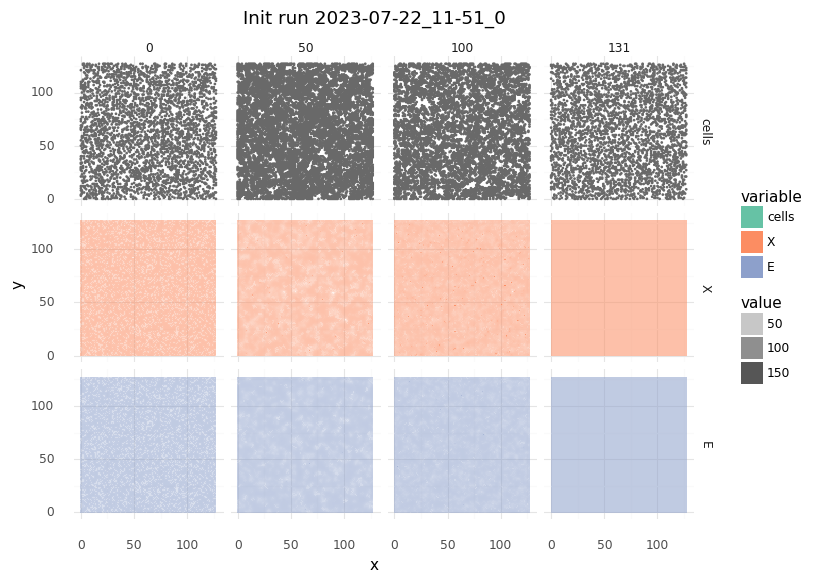

<ggplot: (8752472696229)>

In [27]:
name = "2023-07-22_11-51_0"
df = get_run_overview(world=world, name=name, molecules=["X", "E"])

axis_lims = (0, world.map_size)
(ggplot(df)
    + geom_point(aes(y="y", x="x"), size=0.1, color="dimgray", data=df[df["variable"] == "cells"])
    + geom_tile(aes(y="y", x="x", alpha="value", fill="variable"), data=df[df["variable"] != "cells"])
    + coord_fixed(ratio=1, xlim=axis_lims, ylim=axis_lims)
    + scale_fill_brewer(type="Qualitative", palette="Set2")
    + facet_grid("variable ~ step")
    + ggtitle(f"Init run {name}")
    + theme(figure_size=(8, 8)))

## Training

The `train-pathway` runs tried to teach cells the WL pathway in 5 stages (`WL-0` to `WL-4`).
For each run 2 trials were done and only successful runs would procede to the next stage.
So, the final cells of one run is used for the next run.
The origin of initial cells for a run are described in `init-label`.

An overview of all WL training runs.
The WL pathway was introduced in 5 stages (`WL-0` to `WL-4`).
Each stage had 3 phases:

1. **init** Cells would grow with a low mutation rate in a rich medium that resembles the final medium of the previous run.
2. **adapt** Some substrates are removed from the medium, but all cells recieve genes that they can use to creates these substrates.
  Mutation rate is elevated during this phase.
3. **final** Cells continue to grow in the adapt-medium at a low mutation rate.

To advance each phase cells need to grow for a certain amount of time at an average growth rate above a certain treshold.
This progress is tracked as a scalar from 0 to 100%.
Only successful runs advance to the next stage.
Each run was repeated in 2 trials.

In [3]:
def load_scalars(scalars: list[dict], purpose: str) -> pd.DataFrame:
    records = []
    for _, row in hparams.loc[hparams["purpose"] == purpose].iterrows():
        event_dir = RUNS_DIR / row["name"]
        tf_ea = event_accumulator.EventAccumulator(str(event_dir))
        tf_ea.Reload()
        for scalar, variable in scalars:
            for obj in tf_ea.Scalars(scalar):
                records.append({
                    "name": row["name"],
                    "variable": variable,
                    "value": obj.value,
                    "step": obj.step,
                    "pathway-label": row.get("pathway-label"),
                    "trial": row["trial"]
                })

    df = pd.DataFrame.from_records(records)
    df["variable"] = pd.Categorical(df["variable"], categories=[d[1] for d in scalars])
    return df

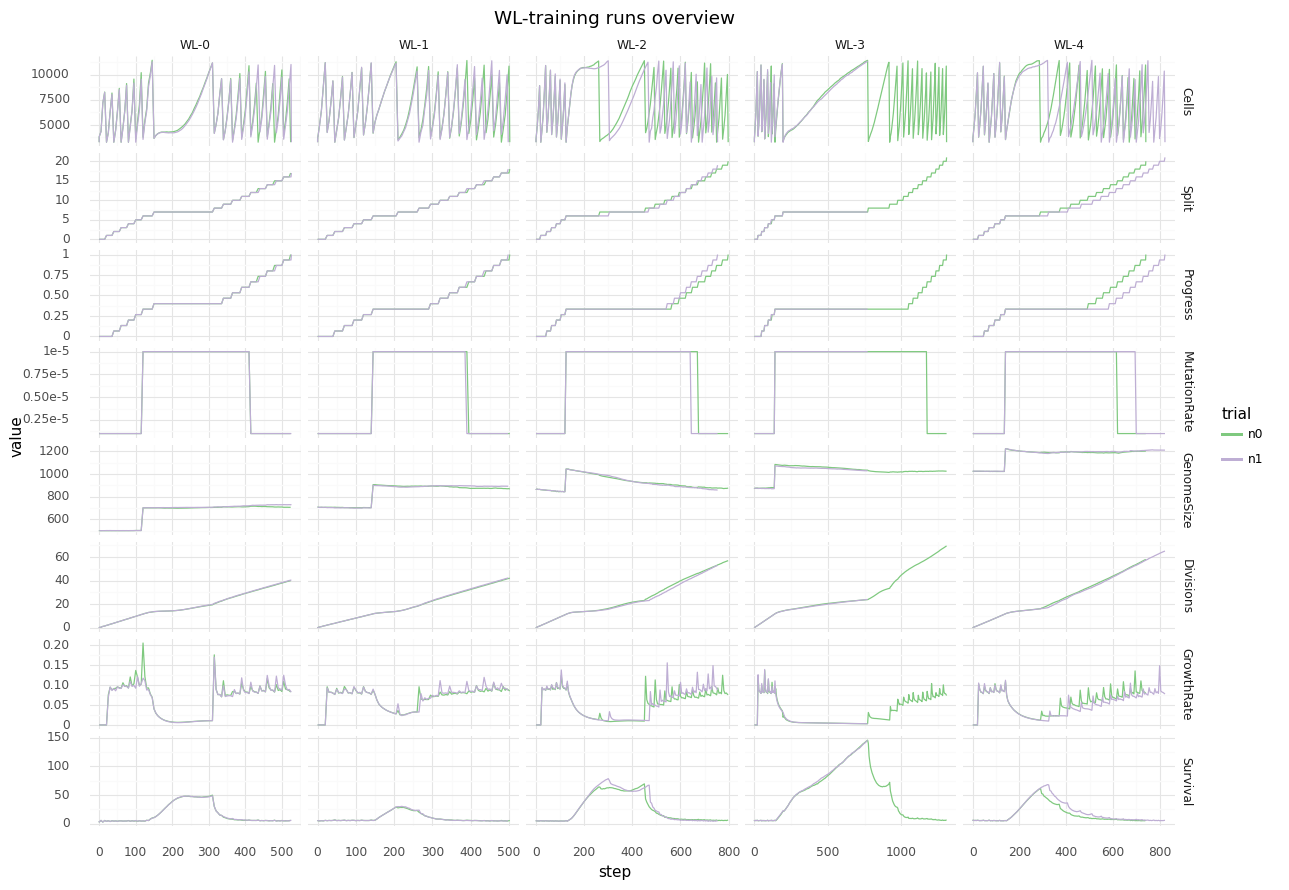

<ggplot: (8752478888528)>

In [9]:
scalars = [
    ("Cells/Total", "Cells"),
    ("Other/Split", "Split"),
    ("Other/Progress", "Progress"),
    ("Other/MutationRate", "MutationRate"),
    ("Cells/GenomeSize", "GenomeSize"),
    ("Cells/Divisions", "Divisions"),
    ("Cells/GrowthRate", "GrowthRate"),
    ("Cells/Survival", "Survival")
]
df = load_scalars(scalars=scalars, purpose="train-pathway")

(ggplot(df)
    + geom_line(aes(y="value", x="step", group="name", color="trial"))
    + facet_grid("variable ~ pathway-label", scales="free")
    + scale_color_brewer(type="Qualitative", palette="Accent")
    + ggtitle("WL-training runs overview")
    + theme(figure_size=(14, 10)))

### Validation runs

The final cells of successful `WL-4` runs were then validated in a Chemostat.
Here, they were just grown in the final minimal medium for 1000 steps at low mutation rates.

The only substrates in this medium are CO2 (as carbon source) and E (as energy source).
The Chemostat worked in a way that it would always add CO2 and E in the middle and remove it on the edges.
This creates a 2D CO2 and E gradient (see plots below).

Naturally, it is easy for cells to survive in the middle, and hard on the outskirts.
First, only cells that were located in the very middle survived.
All others died.
This confirmed their E and CO2 dependence and their ability to create X from E and CO2 alone.
Over time, cells started to grow further out from the middle.

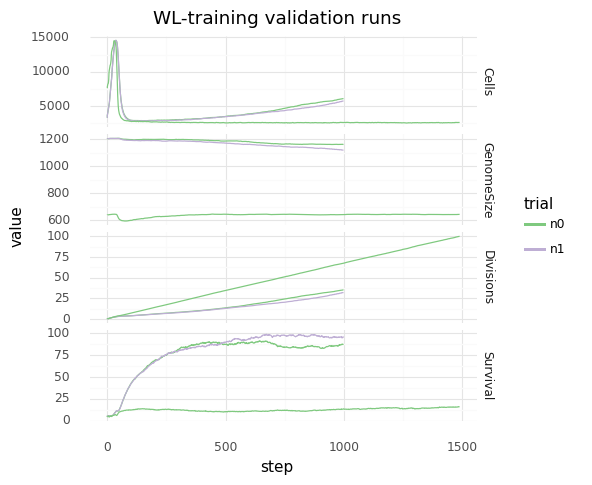

<ggplot: (8766205854000)>

In [301]:
scalars = [
    ("Cells/Total", "Cells"),
    ("Cells/GenomeSize", "GenomeSize"),
    ("Cells/Divisions", "Divisions"),
    ("Cells/Survival", "Survival")
]
df = load_scalars(scalars=scalars, purpose="validate-cells")

(ggplot(df)
    + geom_line(aes(y="value", x="step", group="name", color="trial"))
    + facet_grid("variable ~ .", scales="free")
    + scale_color_brewer(type="Qualitative", palette="Accent")
    + ggtitle("WL-training validation runs")
    + theme(figure_size=(5, 5)))

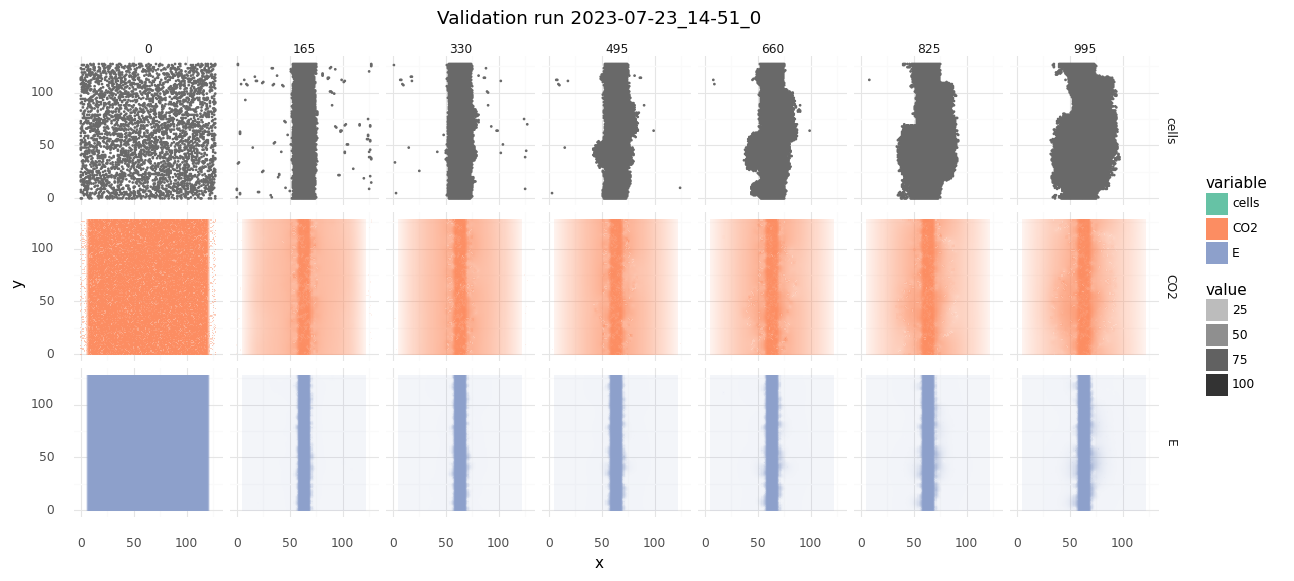

<ggplot: (8766118421084)>

In [303]:
name = "2023-07-23_14-51_0"
df = get_run_overview(world=world, name=name, molecules=["CO2", "E"])

axis_lims = (0, world.map_size)
(ggplot(df)
    + geom_point(aes(y="y", x="x"), size=0.1, color="dimgray", data=df[df["variable"] == "cells"])
    + geom_tile(aes(y="y", x="x", alpha="value", fill="variable"), data=df[df["variable"] != "cells"])
    + coord_fixed(ratio=1, xlim=axis_lims, ylim=axis_lims)
    + scale_fill_brewer(type="Qualitative", palette="Set2")
    + facet_grid("variable ~ step")
    + ggtitle(f"Validation run {name}")
    + theme(figure_size=(14, 9)))

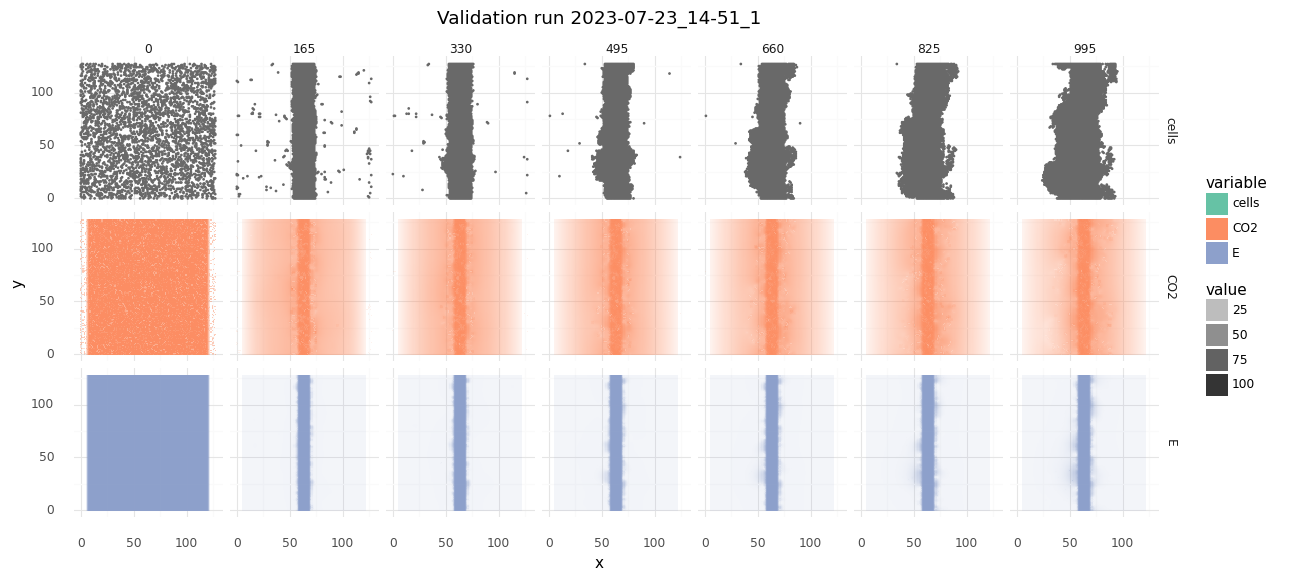

<ggplot: (8766118329951)>

In [304]:
name = "2023-07-23_14-51_1"
df = get_run_overview(world=world, name=name, molecules=["CO2", "E"])

axis_lims = (0, world.map_size)
(ggplot(df)
    + geom_point(aes(y="y", x="x"), size=0.1, color="dimgray", data=df[df["variable"] == "cells"])
    + geom_tile(aes(y="y", x="x", alpha="value", fill="variable"), data=df[df["variable"] != "cells"])
    + coord_fixed(ratio=1, xlim=axis_lims, ylim=axis_lims)
    + scale_fill_brewer(type="Qualitative", palette="Set2")
    + facet_grid("variable ~ step")
    + ggtitle(f"Validation run {name}")
    + theme(figure_size=(14, 9)))

## Result of 2023-07-23_14-51_0

This is a closer look at the final state of **run 2023-07-23_14-51_0** at its last recorded step **step 995**.
I was interested in how exactly the proteomes of these cells looked like and whether it was a homogenous cell culture.

In [305]:
def load_state(slug: str) -> ms.World:
    world = ms.World.from_file(rundir=RUNS_DIR)
    world.kill_cells(cell_idxs=list(range(world.n_cells)))  # fix github.com/mRcSchwering/magic-soup/issues/37
    world.load_state(statedir=RUNS_DIR / slug)
    return world

def summarize_proteomes(world: ms.World) -> list[list[str]]:
    out = []
    for cell_i in range(world.n_cells):
        cell = world.get_cell(by_idx=cell_i)
        out.append([str(d) for d in cell.proteome])
    return out

In [306]:
state_name = "2023-07-23_14-51_0/step=995"
world = load_state(slug=state_name)
all_cell_prots = summarize_proteomes(world=world)

### 2023-07-23_14-51_0 Composition

Here, some descriptive statistics are derived for all cells at once.
_Genome size_, _proteins/genome_, _domains/protein_ distributions describe overall genome and proteome compositions.
_Labels_ show how selective cells grow.
At the beginning of the Chemostat run each of the 1000 initial cells had a unique label.
When a cell divides it keeps its ancestor label.
The histogram shows the frequency of each label index after sorting for frequency.
about 70% of labels disappeared completely, one label alone now makes up about half of all cells.

In [6]:
def get_genome_composition(proteomes: list[list[str]], world: ms.World) -> pd.DataFrame:
    sorted_labels = [d[0] for d in Counter(world.labels).most_common()]
    records = []
    for cell_i, (prots, genome, label) in enumerate(zip(proteomes, world.genomes, world.labels)):
        prots = [d for d in prots if len(d) > 0]
        records.append({"cell": cell_i, "var": "label", "val": sorted_labels.index(label)})
        records.append({"cell": cell_i, "var": "genome size", "val": len(genome)})
        records.append({"cell": cell_i, "var": "proteins/genome", "val": len(prots)})
        if len(prots) > 0:
            for prot in prots:
                n = 0 if len(prot) == 0 else len(prot.split("|"))
                records.append({"cell": cell_i, "var": "domains/protein", "val": n})
    
    df = pd.DataFrame.from_records(records)
    df["var"] = pd.Categorical(df["var"], categories=["genome size", "proteins/genome", "domains/protein", "label"])
    return df

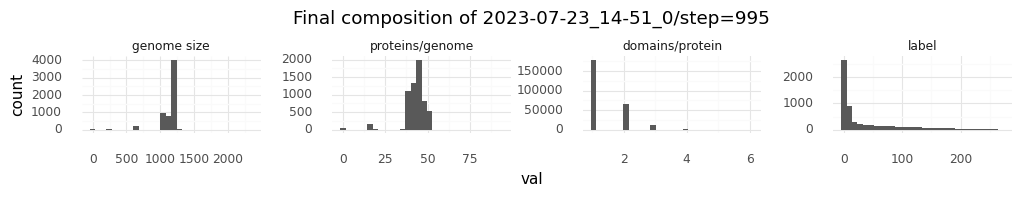

<ggplot: (8766060346885)>

In [307]:
df = get_genome_composition(proteomes=all_cell_prots, world=world)
(ggplot(df)
    + geom_histogram(aes(x="val"), bins=30)
    + facet_wrap("var", scales="free", ncol=4)
    + ggtitle(f"Final composition of {state_name}")
    + theme(figure_size=(12, 1), subplots_adjust={'wspace': 0.4}))

### 2023-07-23_14-51_0 Common proteins

Here, is a summary of all proteins found in at least 30% of cells.
As a simplification, only qualitative parameters of a protein are regarded.
Parameters like $K_M$ and $V_{max}$ are ignored.
This is only a bulk view at all cells at the same time.
It shows overall common proteins, but it doesn't show whether these proteins are all together in one cell, or scatter across many different cells.

In [308]:
def get_protein_counts(proteomes: list[list[str]]) -> pd.DataFrame:
    cnts = {}
    for prots in proteomes:
        for prot in set(prots):
            if prot not in cnts:
                cnts[prot] = 0
            cnts[prot] += 1

    df = pd.DataFrame.from_records([{"protein": k, "n": d} for k, d in cnts.items()])
    df["pct"] = df["n"] / len(all_cell_prots) * 100
    df = df.loc[df["protein"] != ""]
    df.loc[:, "type"] = "transporter"
    df.loc[df["protein"].str.contains("<->"), "type"] = "catalytic"
    df.sort_values("pct", ascending=False, inplace=True)
    return df

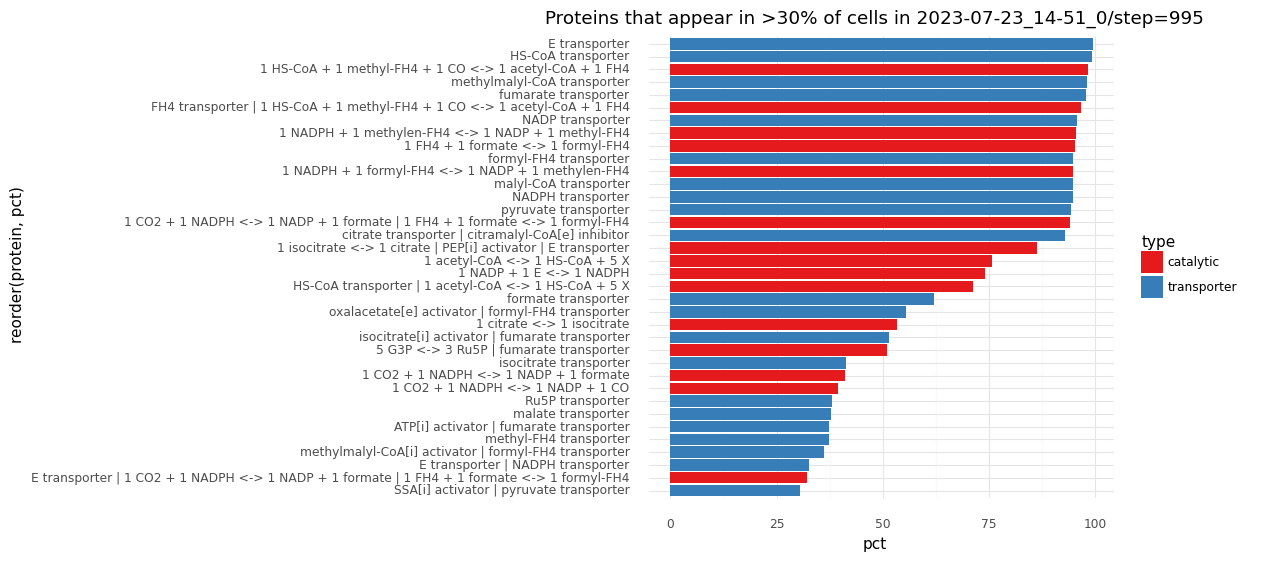

<ggplot: (8766181041834)>

In [309]:
top_n_pct = 30
df = get_protein_counts(proteomes=all_cell_prots)
(ggplot(df.loc[df["pct"] > top_n_pct])
    + geom_col(aes(y="pct", x="reorder(protein, pct)", fill="type"))
    + coord_flip()
    + scale_fill_brewer(type="Qualitative", palette="Set1")
    + ggtitle(f"Proteins that appear in >{top_n_pct}% of cells in {state_name}")
    + theme(figure_size=(6, 6)))

### 2023-07-23_14-51_0 Cell clustering

Above was only a look at all cells together in bulk.
Here, I wanted to extract different celllines by clustering them based on their proteome.
The feature matrix $X$ for this clustering is derived from forward and backward reaction stoichiometric numbers of all proteins.
Thus, I am only considering whether a cell can convert a certain molecule species or not.
I am not considering reaction parameters such as $K_M$ or $V_{max}$, or how many version of a protein a cell has.
The clustering method is _DBSCAN_ with manhattan distance.
Parameters `eps` and `min_samples` were chosen so that most cells belong to a cluster, but not too many clusters are created.

In [310]:
def cluster_cells(world: ms.World, eps: float, min_samples=100) -> list[str]:
    rgt = (world.kinetics.Nb[:world.n_cells] > 0).sum(dim=1).numpy()
    lft = (world.kinetics.Nf[:world.n_cells] > 0).sum(dim=1).numpy()
    X = np.concatenate([rgt, lft], axis=1)
    model = DBSCAN(eps=eps, min_samples=min_samples, metric="manhattan")
    return [f"c{d}" if d > 0 else "-" for d in model.fit(X).labels_.tolist()]

def identify_clusters(world: ms.World, clusters: list[str]) -> pd.DataFrame:
    cats = sorted(list(set([d for d in clusters if d != "-"])))
    records = []
    xs = world.cell_positions[:, 0].tolist()
    ys = world.cell_positions[:, 1].tolist()
    for x, y, c, g in zip(xs, ys, clusters, world.genomes):
        records.append({"x": x, "y": y, "cluster": c, "size": len(g)})
    df = pd.DataFrame.from_records(records)
    df["cluster"] = pd.Categorical(df["cluster"], categories=cats, ordered=True)
    return df

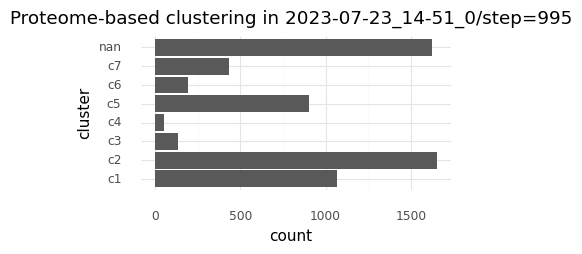

<ggplot: (8766062740838)>

In [316]:
clusters = cluster_cells(world=world, eps=10.0, min_samples=50)
sorted_clusters = [d[0] for d in Counter(clusters).most_common()]
df = identify_clusters(world=world, clusters=clusters)

(ggplot(df)
    + geom_bar(aes(x="cluster"))
    + coord_flip()
    + ggtitle(f"Proteome-based clustering in {state_name}")
    + theme(figure_size=(4, 2)))

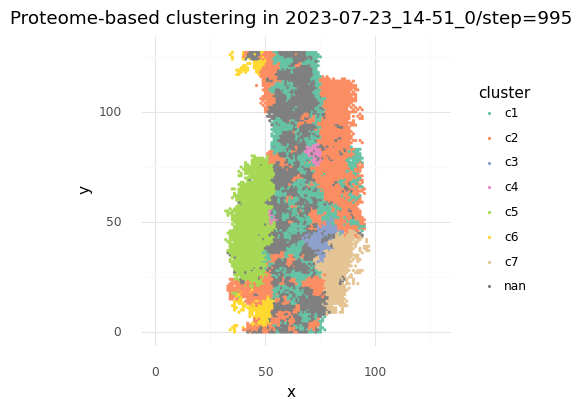

<ggplot: (8766047650931)>

In [317]:
axis_lims = (0, world.map_size)
(ggplot(df)
    + geom_point(aes(y="y", x="x", color="cluster"), size=0.3)
    + coord_fixed(ratio=1, xlim=axis_lims, ylim=axis_lims)
    + scale_color_brewer(type="Qualitative", palette="Set2")
    + ggtitle(f"Proteome-based clustering in {state_name}")
    + theme(figure_size=(4, 3)))

There is still some variability among cells within one cluster.
To make further analysis easier I decided to choose one representative genome for each cluster.
This would be the most common genome among all genomes inside the cluster.
The plot below shows how distinctive each cluster genome distribution is and how representative each representative genome is.

In [318]:
def get_common_genomes(genomes: list, clusters: list[str], top_n: int) -> pd.DataFrame:
    sorted_clusters = [d[0] for d in Counter(clusters).most_common()]

    dfs = []
    for cluster in sorted_clusters:
        cell_idxs = [i for i, d in enumerate(clusters) if d == cluster]
        genome_cnts = Counter([genomes[d] for d in cell_idxs])
        records = [
            {"genome": f"g{genomes.index(k)}", "n": d, "cluster": cluster}
            for k, d in genome_cnts.items()
        ]
        df = pd.DataFrame.from_records(records).sort_values("n", ascending=False).iloc[:top_n]
        dfs.append(df)

    return pd.concat(dfs).reset_index()

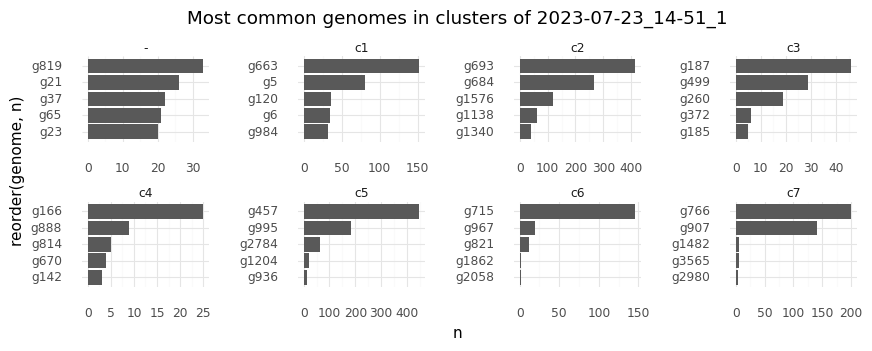

<ggplot: (8766047665198)>

In [319]:
df = get_common_genomes(genomes=world.genomes, clusters=clusters, top_n=5)
clst_genome_map = df[df["cluster"] != "-"].groupby("cluster", as_index=True)["genome"].first().to_dict()

(ggplot(df)
    + geom_col(aes(x="reorder(genome, n)", y="n"))
    + facet_wrap("cluster", ncol=4, scales="free")
    + coord_flip()
    + ggtitle(f"Most common genomes in clusters of {name}")
    + theme(figure_size=(10, 3), subplots_adjust={'wspace': 0.7, 'hspace': 0.7}))

### 2023-07-23_14-51_0 Cluster proteomes

From the derived genomes above, all proteomes are compared.
Again, for simplification parameters like $K_M$ and $V_{max}$ are ignored.
The plot tries to show the qualitative capabilities of each cluster.
While all required capabilities of the WL pathway exist in one or more clusters,
not a single cluster has all required capabilities at once.
This different clusters depend on each other to grow on CO2 and E alone.

In [320]:
def get_proteomes_summary(world: ms.World, clst_2_genome: dict[str, str]) -> pd.DataFrame:
    out = []
    for clst, genome_label in clst_2_genome.items():
        cell = world.get_cell(by_idx=int(genome_label[1:]))
        strs = [str(d) for d in cell.proteome if str(d) != ""]
        out.extend([{"protein": d, "n": 1, "label": genome_label, "cluster": clst} for d in strs])
    
    df =  pd.DataFrame.from_records(out)
    df.loc[:, "type"] = "transporter"
    df.loc[df["protein"].str.contains("<->"), "type"] = "catalytic"
    return df

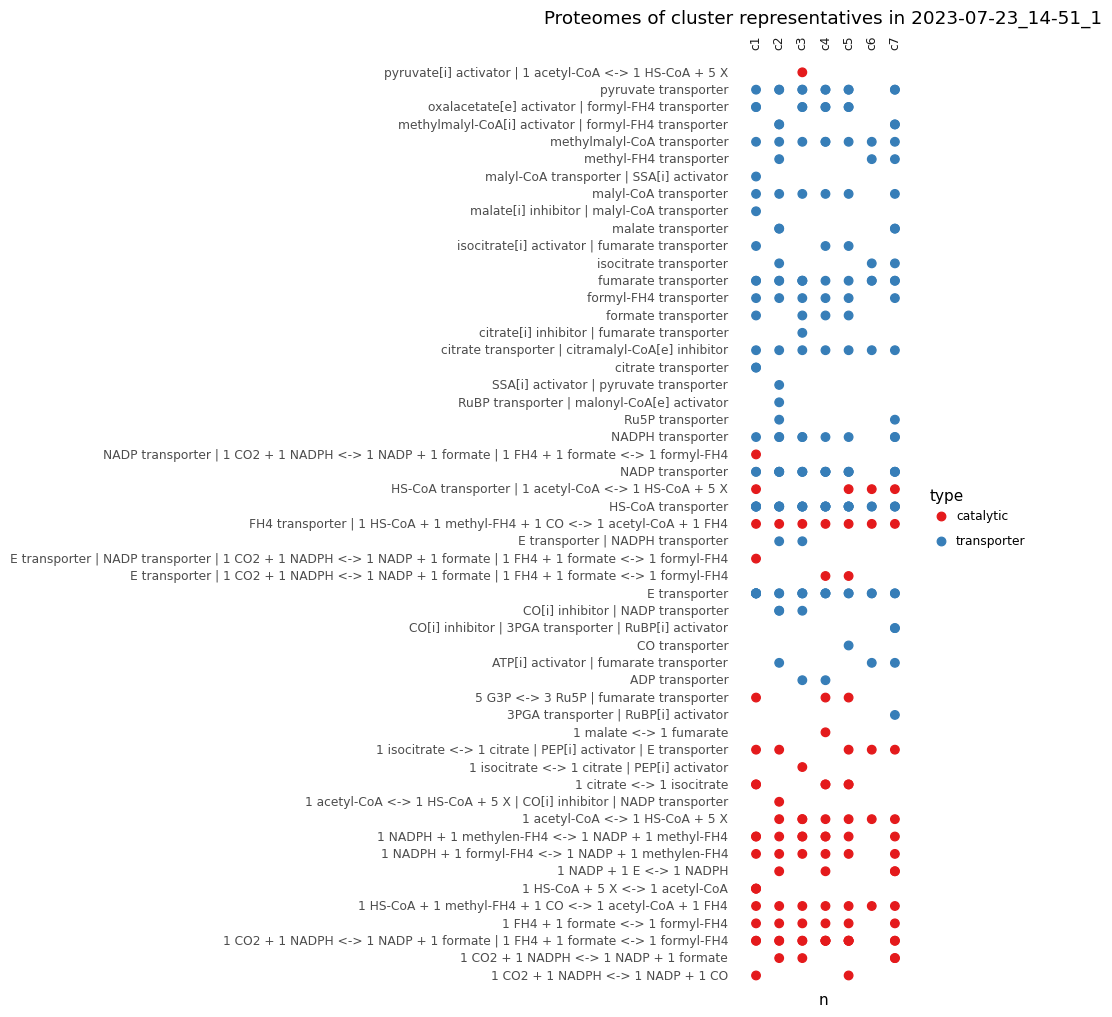

<ggplot: (8766047376889)>

In [321]:
df = get_proteomes_summary(world=world, clst_2_genome=clst_genome_map)
(ggplot(df)
    + geom_point(aes(x="protein", y="n", color="type"), size=3)
    + coord_flip()
    + facet_grid(". ~ cluster")
    + scale_color_brewer(type="Qualitative", palette="Set1")
    + ggtitle(f"Proteomes of cluster representatives in {name}")
    + theme(figure_size=(2, 12))
    + theme(strip_text_x=element_text(angle=90, margin={"b": 10}))
    + theme(axis_title_y=element_blank(), axis_text_x=element_blank())
    + theme(panel_grid_major=element_blank(), panel_grid_minor=element_blank()))

### 2023-07-23_14-51_0 Cluster concentrations

Here, I want to get an idea about the environment of these cells.
I am looking at intra- and extracellular molecule concentrations for a selection of molecule species.
This just represents a single time step.
But since each cluster contains many cells, and even the representative genome of each cluster is carried by many cells,
looking at the molecule distributions accross these cells should be sufficient.
I selected the molecules based on catalytic reactions that each cluster representative can catalyze.

In [322]:
def get_mol_concentrations(cluster_2_genome: dict[str, str], molnames: list[str], world: ms.World) -> pd.DataFrame:
    genome_map = {k: world.genomes[int(d[1:])] for k, d in cluster_2_genome.items()}
    clst_map = {k: [i for i, d in enumerate(world.genomes) if d == v] for k, v in genome_map.items()}
    mol_map = world.chemistry.molname_2_idx

    records = []
    for clst, cell_idxs in clst_map.items():
        for ci in cell_idxs:
            kwargs = {"cluster": clst, "cell": ci}
            pos = world.cell_positions[ci]
            int_molecules = world.cell_molecules[ci, :]
            ext_molecules = world.molecule_map[:, pos[0], pos[1]]
            for mol in molnames:
                mi = mol_map[mol]
                records.append({**kwargs, "mol": mol, "x": int_molecules[mi].item(), "loc": "i"})
                records.append({**kwargs, "mol": mol, "x": ext_molecules[mi].item(), "loc": "e"})
    df = pd.DataFrame.from_records(records)
    df["mol"] = pd.Categorical(df["mol"], categories=molnames)
    return df

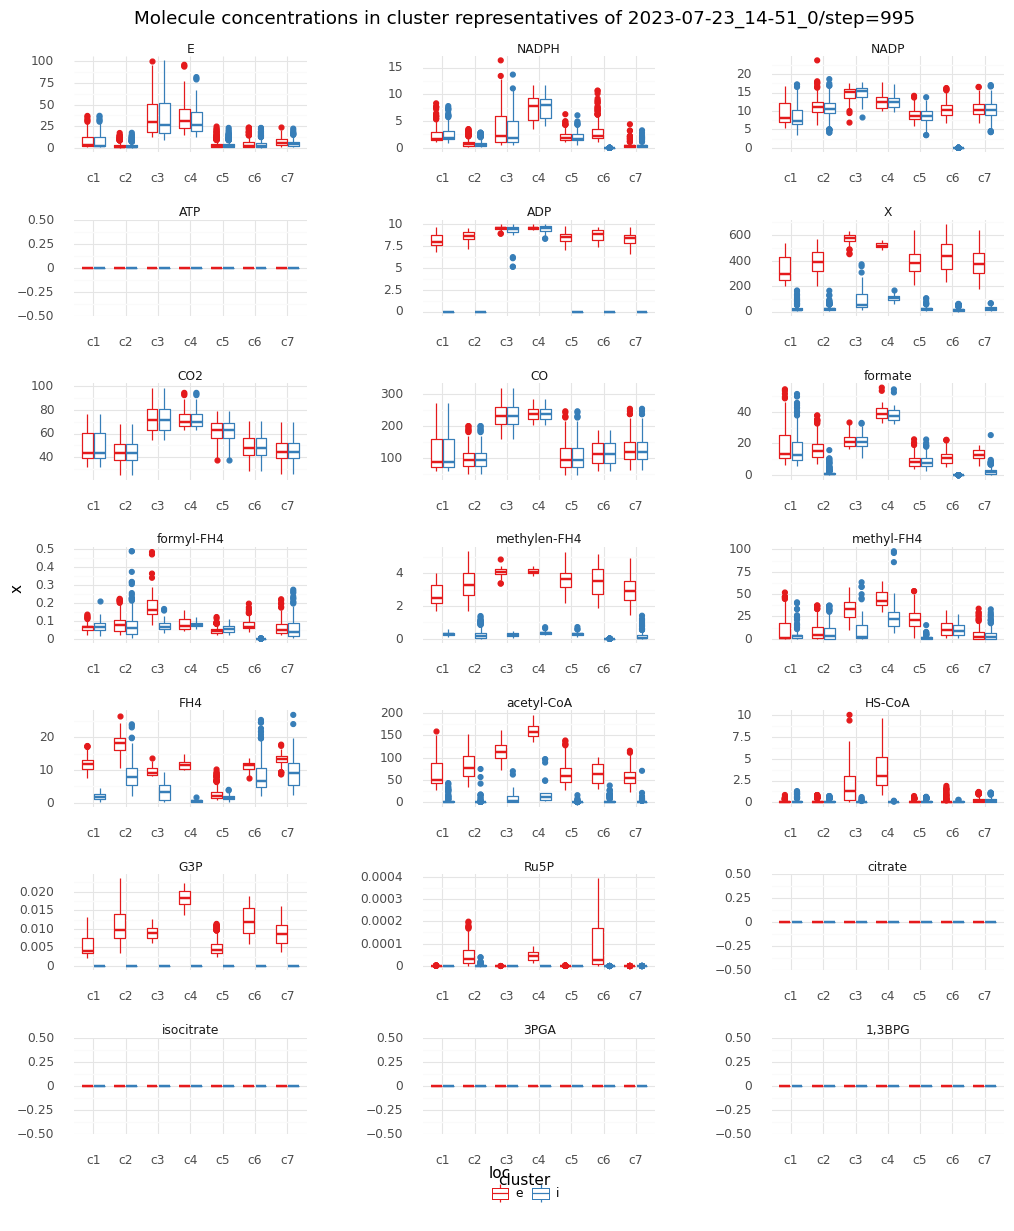

<ggplot: (8766060347086)>

In [323]:
df = get_mol_concentrations(
    cluster_2_genome=clst_genome_map,
    molnames=[
        "E", "NADPH", "NADP", "ATP", "ADP",
        "X", "CO2", "CO", "formate",
        "formyl-FH4", "methylen-FH4", "methyl-FH4", "FH4",
        "acetyl-CoA", "HS-CoA",
        "G3P", "Ru5P", "citrate", "isocitrate", "3PGA", "1,3BPG"
    ],
    world=world
)

(ggplot(df)
    + geom_boxplot(aes(x="cluster", y="x", color="loc"))
    + facet_wrap("mol", ncol=3, scales="free")
    + scale_color_brewer(type="Qualitative", palette="Set1")
    + ggtitle(f"Molecule concentrations in cluster representatives of {state_name}")
    + theme(legend_position="bottom")
    + theme(figure_size=(12, 14), subplots_adjust={'wspace': 0.5, 'hspace': 0.7}))

## Result of 2023-07-23_14-51_1

This is a closer look at the final state of **run 2023-07-23_14-51_1** at its last recorded step **step 995**.
I was interested in how exactly the proteomes of these cells looked like and whether it was a homogenous cell culture.

In [14]:
state_name = "2023-07-23_14-51_1/step=995"
world = load_state(slug=state_name)
all_cell_prots = summarize_proteomes(world=world)

### 2023-07-23_14-51_1 Composition

Here, some descriptive statistics are derived for all cells at once.
_Genome size_, _proteins/genome_, _domains/protein_ distributions describe overall genome and proteome compositions.
_Labels_ show how selective cells grow.
At the beginning of the Chemostat run each of the 1000 initial cells had a unique label.
When a cell divides it keeps its ancestor label.
The histogram shows the frequency of each label index after sorting for frequency.
about 70% of labels disappeared completely, one label alone now makes up about half of all cells.

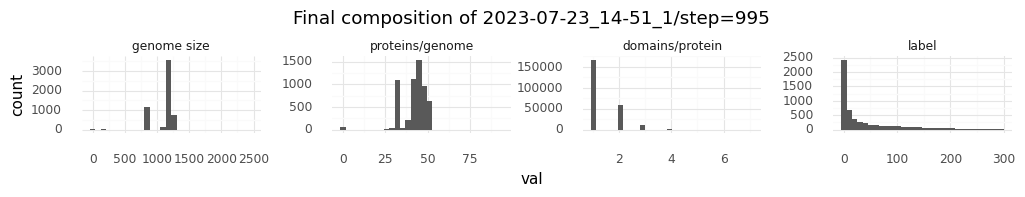

<ggplot: (8768911984142)>

In [15]:
df = get_genome_composition(proteomes=all_cell_prots, world=world)
(ggplot(df)
    + geom_histogram(aes(x="val"), bins=30)
    + facet_wrap("var", scales="free", ncol=4)
    + ggtitle(f"Final composition of {state_name}")
    + theme(figure_size=(12, 1), subplots_adjust={'wspace': 0.4}))

### 2023-07-23_14-51_1 Common proteins

Here, is a summary of all proteins found in at least 30% of cells.
As a simplification, only qualitative parameters of a protein are regarded.
Parameters like $K_M$ and $V_{max}$ are ignored.
This is only a bulk view at all cells at the same time.
It shows overall common proteins, but it doesn't show whether these proteins are all together in one cell, or scatter across many different cells.

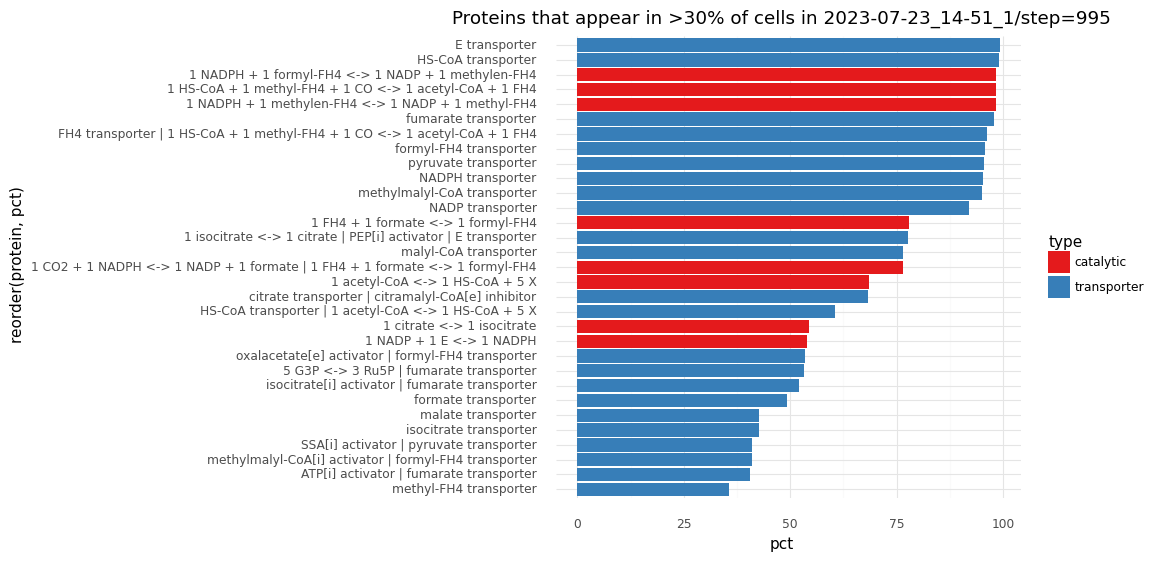

<ggplot: (8768911564903)>

In [16]:
top_n_pct = 30
df = get_protein_counts(proteomes=all_cell_prots)
(ggplot(df.loc[df["pct"] > top_n_pct])
    + geom_col(aes(y="pct", x="reorder(protein, pct)", fill="type"))
    + coord_flip()
    + scale_fill_brewer(type="Qualitative", palette="Set1")
    + ggtitle(f"Proteins that appear in >{top_n_pct}% of cells in {state_name}")
    + theme(figure_size=(6, 6)))

### 2023-07-23_14-51_1 Cell clustering

Above was only a look at all cells together in bulk.
Here, I wanted to extract different celllines by clustering them based on their proteome.
The feature matrix $X$ for this clustering is derived from forward and backward reaction stoichiometric numbers of all proteins.
Thus, I am only considering whether a cell can convert a certain molecule species or not.
I am not considering reaction parameters such as $K_M$ or $V_{max}$, or how many version of a protein a cell has.
The clustering method is _DBSCAN_ with manhattan distance.
Parameters `eps` and `min_samples` were chosen so that most cells belong to a cluster, but not too many clusters are created.

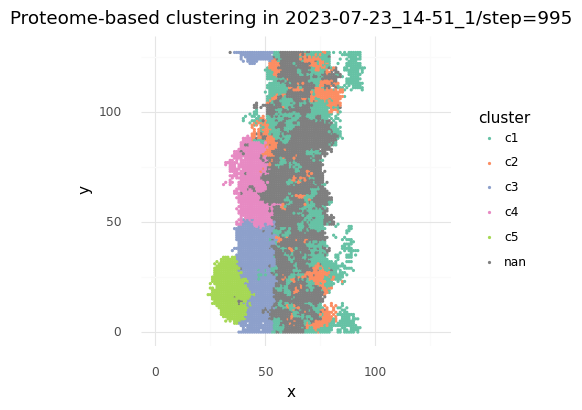

<ggplot: (8768906718088)>

In [17]:
clusters = cluster_cells(world=world, eps=10.0)
sorted_clusters = [d[0] for d in Counter(clusters).most_common()]
df = identify_clusters(world=world, clusters=clusters)

axis_lims = (0, world.map_size)
(ggplot(df)
    + geom_point(aes(y="y", x="x", color="cluster"), size=0.3)
    + coord_fixed(ratio=1, xlim=axis_lims, ylim=axis_lims)
    + scale_color_brewer(type="Qualitative", palette="Set2")
    + ggtitle(f"Proteome-based clustering in {state_name}")
    + theme(figure_size=(4, 3)))

There is still some variability among cells within one cluster.
To make further analysis easier I decided to choose one representative genome for each cluster.
This would be the most common genome among all genomes inside the cluster.
The plot below shows how distinctive each cluster genome distribution is and how representative each representative genome is.

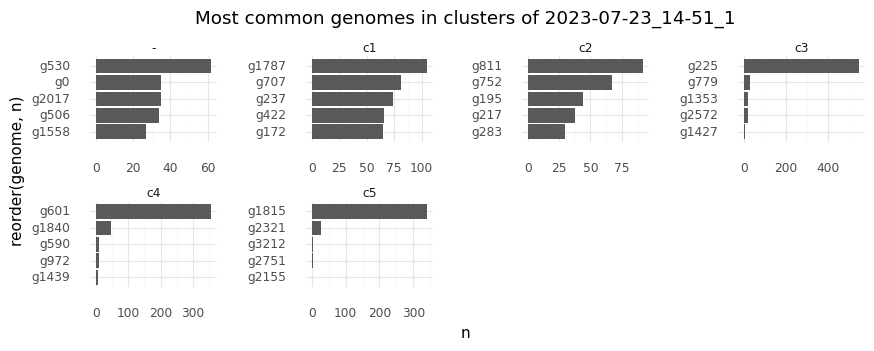

<ggplot: (8768912477455)>

In [18]:
df = get_common_genomes(genomes=world.genomes, clusters=clusters, top_n=5)
clst_genome_map = df[df["cluster"] != "-"].groupby("cluster", as_index=True)["genome"].first().to_dict()

(ggplot(df)
    + geom_col(aes(x="reorder(genome, n)", y="n"))
    + facet_wrap("cluster", ncol=4, scales="free")
    + coord_flip()
    + ggtitle(f"Most common genomes in clusters of {name}")
    + theme(figure_size=(10, 3), subplots_adjust={'wspace': 0.7, 'hspace': 0.7}))

### 2023-07-23_14-51_1 Cluster proteomes

From the derived genomes above, all proteomes are compared.
Again, for simplification parameters like $K_M$ and $V_{max}$ are ignored.
The plot tries to show the qualitative capabilities of each cluster.
While all required capabilities of the WL pathway exist in one or more clusters,
not a single cluster has all required capabilities at once.
This different clusters depend on each other to grow on CO2 and E alone.

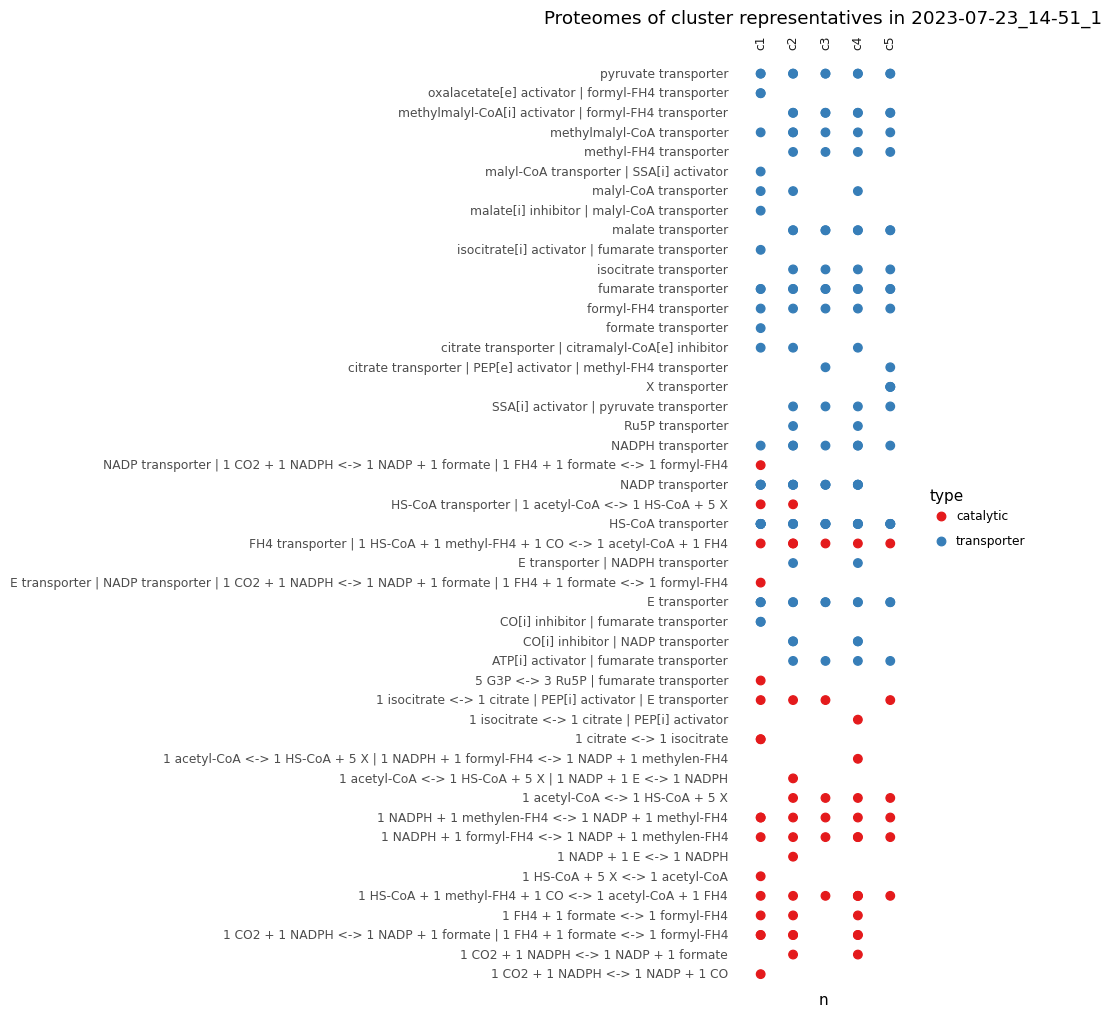

<ggplot: (8768911759303)>

In [19]:
df = get_proteomes_summary(world=world, clst_2_genome=clst_genome_map)
(ggplot(df)
    + geom_point(aes(x="protein", y="n", color="type"), size=3)
    + coord_flip()
    + facet_grid(". ~ cluster")
    + scale_color_brewer(type="Qualitative", palette="Set1")
    + ggtitle(f"Proteomes of cluster representatives in {name}")
    + theme(figure_size=(2, 12))
    + theme(strip_text_x=element_text(angle=90, margin={"b": 10}))
    + theme(axis_title_y=element_blank(), axis_text_x=element_blank())
    + theme(panel_grid_major=element_blank(), panel_grid_minor=element_blank()))

### 2023-07-23_14-51_1 Cluster concentrations

Here, I want to get an idea about the environment of these cells.
I am looking at intra- and extracellular molecule concentrations for a selection of molecule species.
This just represents a single time step.
But since each cluster contains many cells, and even the representative genome of each cluster is carried by many cells,
looking at the molecule distributions accross these cells should be sufficient.
I selected the molecules based on catalytic reactions that each cluster representative can catalyze.

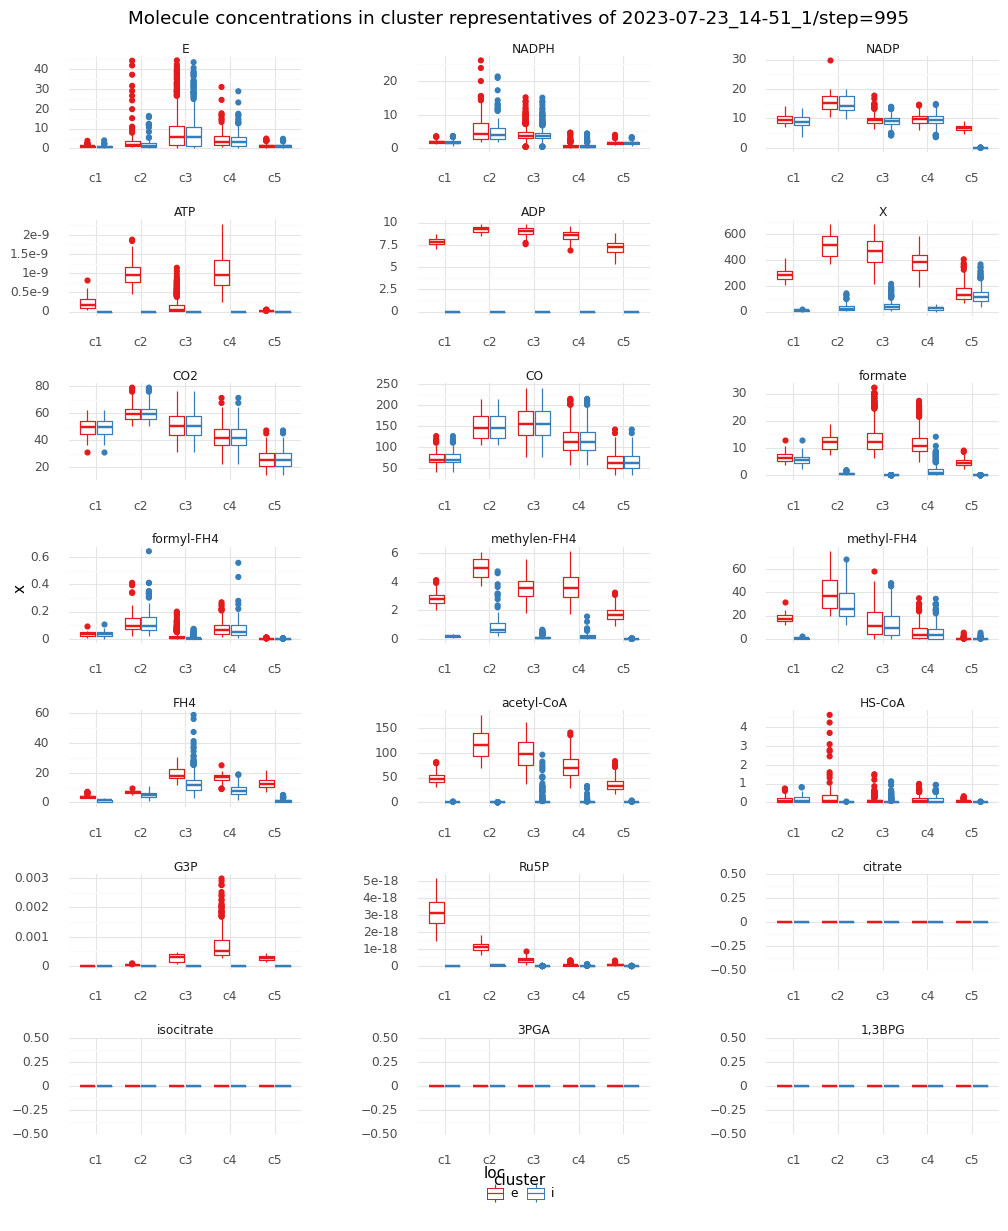

<ggplot: (8768891784385)>

In [20]:
df = get_mol_concentrations(
    cluster_2_genome=clst_genome_map,
    molnames=[
        "E", "NADPH", "NADP", "ATP", "ADP",
        "X", "CO2", "CO", "formate",
        "formyl-FH4", "methylen-FH4", "methyl-FH4", "FH4",
        "acetyl-CoA", "HS-CoA",
        "G3P", "Ru5P", "citrate", "isocitrate", "3PGA", "1,3BPG"
    ],
    world=world
)

(ggplot(df)
    + geom_boxplot(aes(x="cluster", y="x", color="loc"))
    + facet_wrap("mol", ncol=3, scales="free")
    + scale_color_brewer(type="Qualitative", palette="Set1")
    + ggtitle(f"Molecule concentrations in cluster representatives of {state_name}")
    + theme(legend_position="bottom")
    + theme(figure_size=(12, 14), subplots_adjust={'wspace': 0.5, 'hspace': 0.7}))

## Shrink Genomes

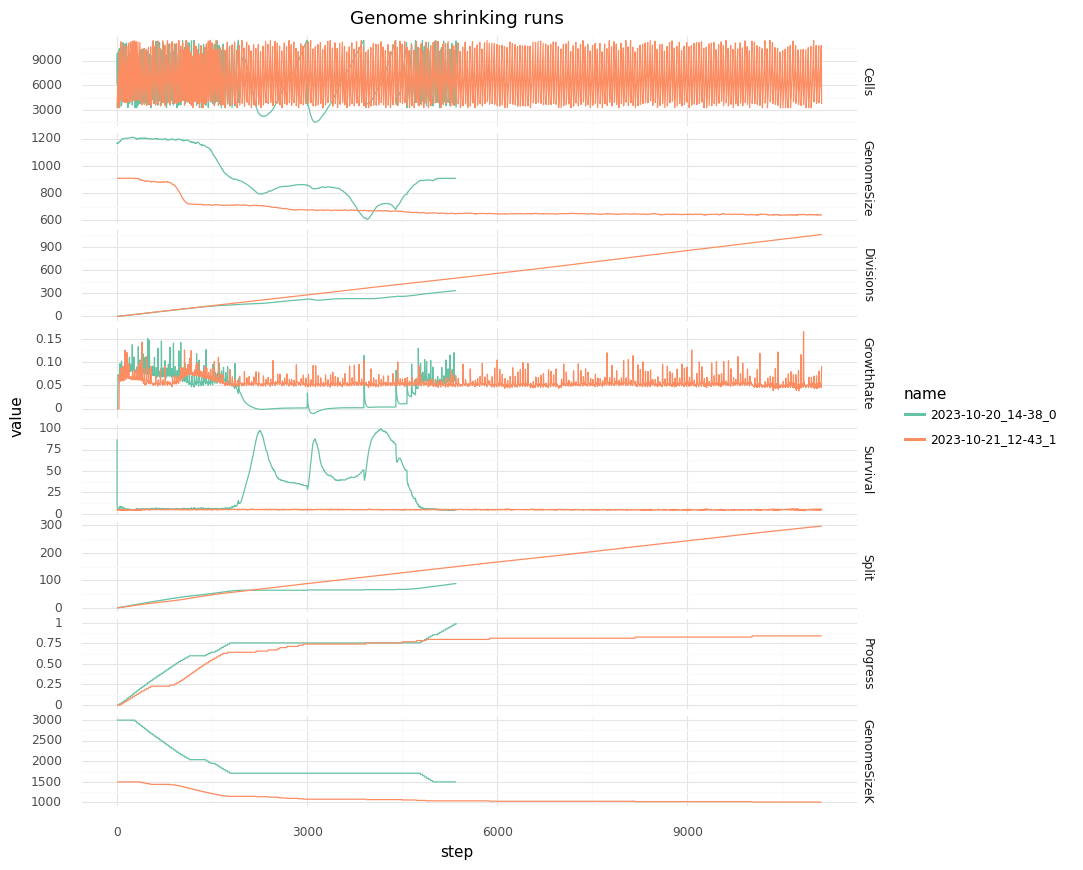

<ggplot: (8766186031681)>

In [12]:
scalars = [
    ("Cells/Total", "Cells"),
    ("Cells/GenomeSize", "GenomeSize"),
    ("Cells/Divisions", "Divisions"),
    ("Cells/GrowthRate", "GrowthRate"),
    ("Cells/Survival", "Survival"),
    ("Other/Split", "Split"),
    ("Other/Progress", "Progress"),
    ("Other/GenomeSizeK", "GenomeSizeK")
]
df = load_scalars(scalars=scalars, purpose="shrink-genomes")

(ggplot(df)
    #+ geom_vline(xintercept=1700, color="gray", linetype="dashed")
    + geom_line(aes(y="value", x="step", group="name", color="name"))
    + facet_grid("variable ~ .", scales="free")
    + scale_color_brewer(type="Qualitative", palette="Set2")
    + ggtitle("Genome shrinking runs")
    + theme(figure_size=(10, 10)))

### 2023-10-19_17-14_0

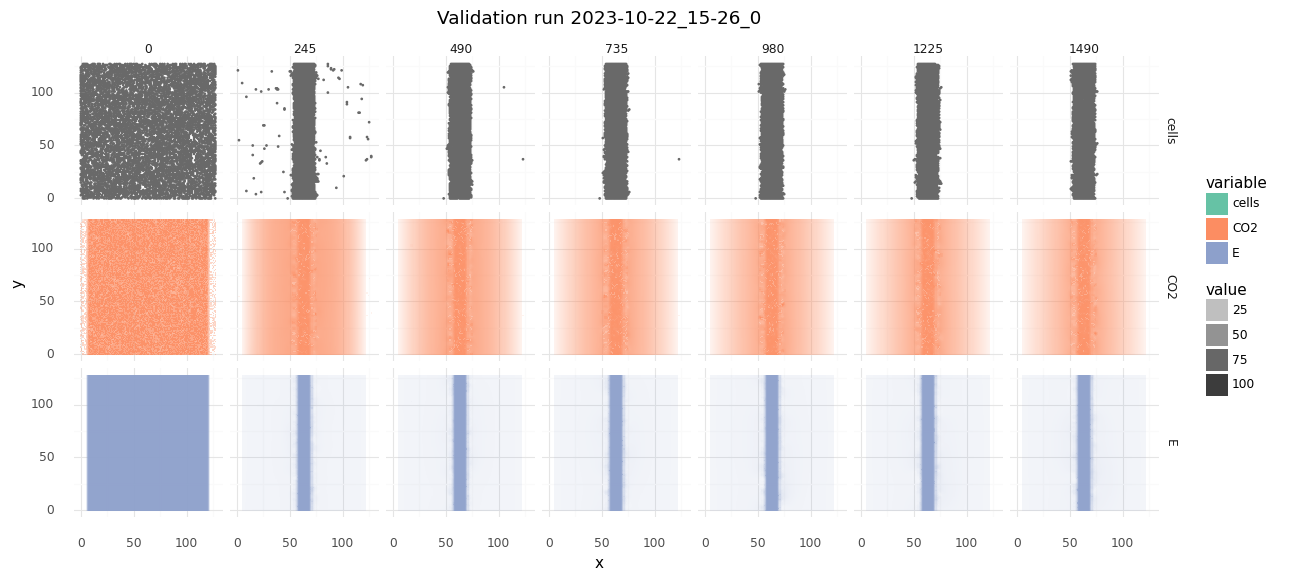

<ggplot: (8766131030263)>

In [13]:
name = "2023-10-22_15-26_0"
df = get_run_overview(world=world, name=name, molecules=["CO2", "E"])

axis_lims = (0, world.map_size)
(ggplot(df)
    + geom_point(aes(y="y", x="x"), size=0.1, color="dimgray", data=df[df["variable"] == "cells"])
    + geom_tile(aes(y="y", x="x", alpha="value", fill="variable"), data=df[df["variable"] != "cells"])
    + coord_fixed(ratio=1, xlim=axis_lims, ylim=axis_lims)
    + scale_fill_brewer(type="Qualitative", palette="Set2")
    + facet_grid("variable ~ step")
    + ggtitle(f"Validation run {name}")
    + theme(figure_size=(14, 9)))

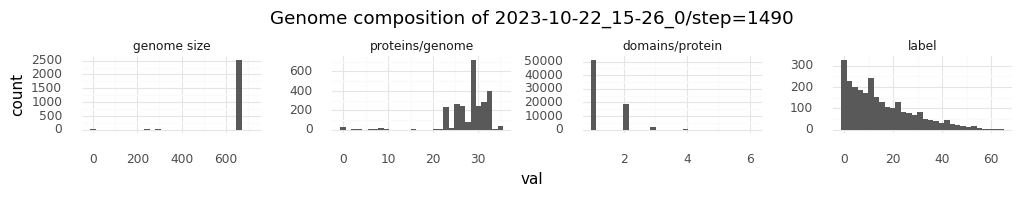

<ggplot: (8766116983884)>

In [14]:
state_name = f"{name}/step=1490"
world = load_state(slug=state_name)
all_cell_prots = summarize_proteomes(world=world)

df = get_genome_composition(proteomes=all_cell_prots, world=world)
(ggplot(df)
    + geom_histogram(aes(x="val"), bins=30)
    + facet_wrap("var", scales="free", ncol=4)
    + ggtitle(f"Genome composition of {state_name}")
    + theme(figure_size=(12, 1), subplots_adjust={'wspace': 0.4}))

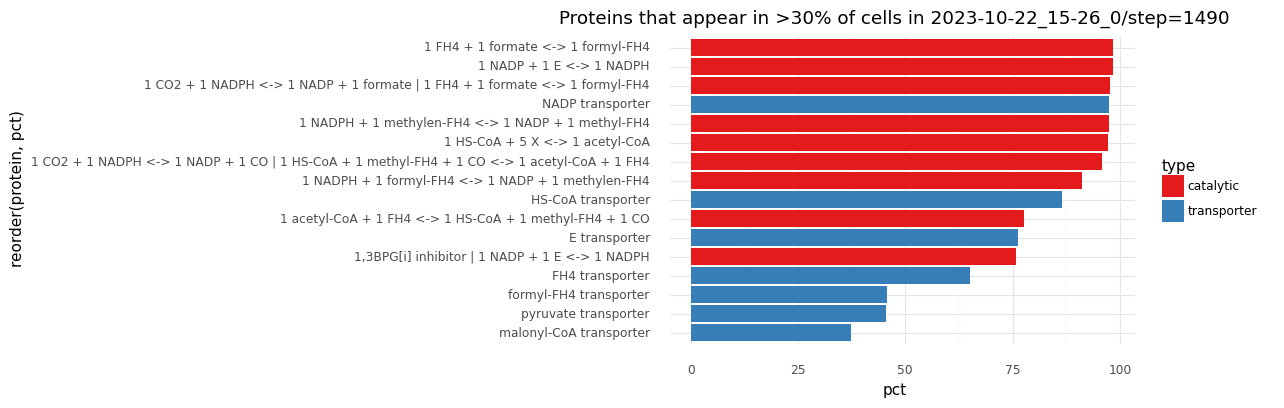

<ggplot: (8766116976379)>

In [17]:
top_n_pct = 30
df = get_protein_counts(proteomes=all_cell_prots)
(ggplot(df.loc[df["pct"] > top_n_pct])
    + geom_col(aes(y="pct", x="reorder(protein, pct)", fill="type"))
    + coord_flip()
    + scale_fill_brewer(type="Qualitative", palette="Set1")
    + ggtitle(f"Proteins that appear in >{top_n_pct}% of cells in {state_name}")
    + theme(figure_size=(6, 4)))

In [18]:
print(df[df["protein"].str.contains("1 NADP \+ 1 CO") & (df["type"] == "catalytic")].iloc[:5].to_string())

                                                                                        protein     n        pct       type
20  1 CO2 + 1 NADPH <-> 1 NADP + 1 CO | 1 HS-CoA + 1 methyl-FH4 + 1 CO <-> 1 acetyl-CoA + 1 FH4  2498  95.745496  catalytic
36                                                            1 NADP + 1 CO <-> 1 CO2 + 1 NADPH   156   5.979302  catalytic
39                                 malonyl-CoA[e] activator | 1 NADP + 1 CO <-> 1 CO2 + 1 NADPH   105   4.024530  catalytic
90                                            1 CO2 + 1 NADPH <-> 1 NADP + 1 CO | X transporter    41   1.571483  catalytic


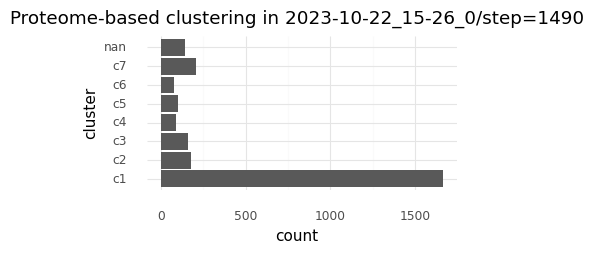

<ggplot: (8766172382139)>

In [274]:
clusters = cluster_cells(world=world, eps=20.0, min_samples=50)
sorted_clusters = [d[0] for d in Counter(clusters).most_common()]
df = identify_clusters(world=world, clusters=clusters)

(ggplot(df)
    + geom_bar(aes(x="cluster"))
    + coord_flip()
    + ggtitle(f"Proteome-based clustering in {state_name}")
    + theme(figure_size=(4, 2)))

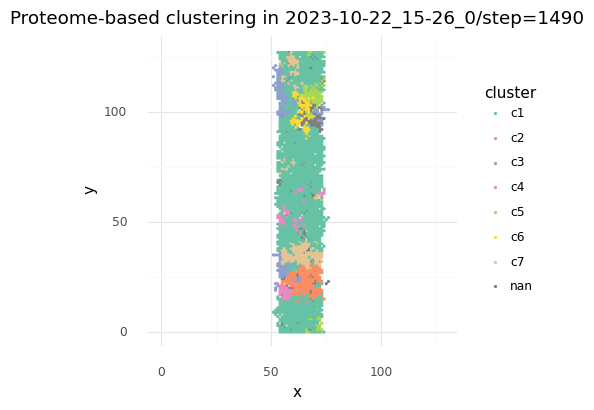

<ggplot: (8766089049392)>

In [35]:
axis_lims = (0, world.map_size)
(ggplot(df)
    + geom_point(aes(y="y", x="x", color="cluster"), size=0.3)
    + coord_fixed(ratio=1, xlim=axis_lims, ylim=axis_lims)
    + scale_color_brewer(type="Qualitative", palette="Set2")
    + ggtitle(f"Proteome-based clustering in {state_name}")
    + theme(figure_size=(4, 3)))

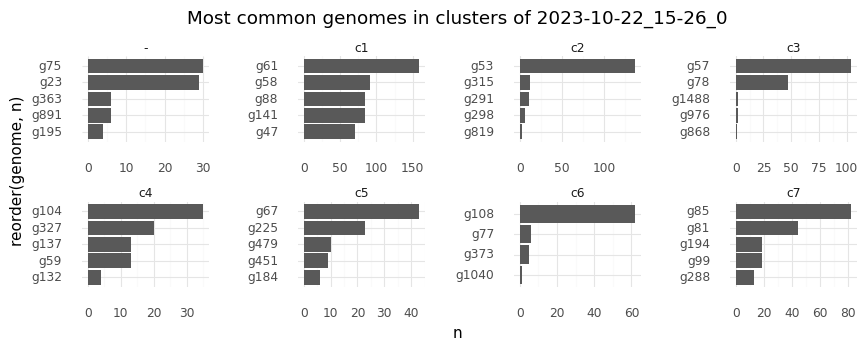

<ggplot: (8766089143621)>

In [37]:
df = get_common_genomes(genomes=world.genomes, clusters=clusters, top_n=5)
clst_genome_map = df[df["cluster"] != "-"].groupby("cluster", as_index=True)["genome"].first().to_dict()

(ggplot(df)
    + geom_col(aes(x="reorder(genome, n)", y="n"))
    + facet_wrap("cluster", ncol=4, scales="free")
    + coord_flip()
    + ggtitle(f"Most common genomes in clusters of {name}")
    + theme(figure_size=(10, 3), subplots_adjust={'wspace': 0.7, 'hspace': 0.7}))

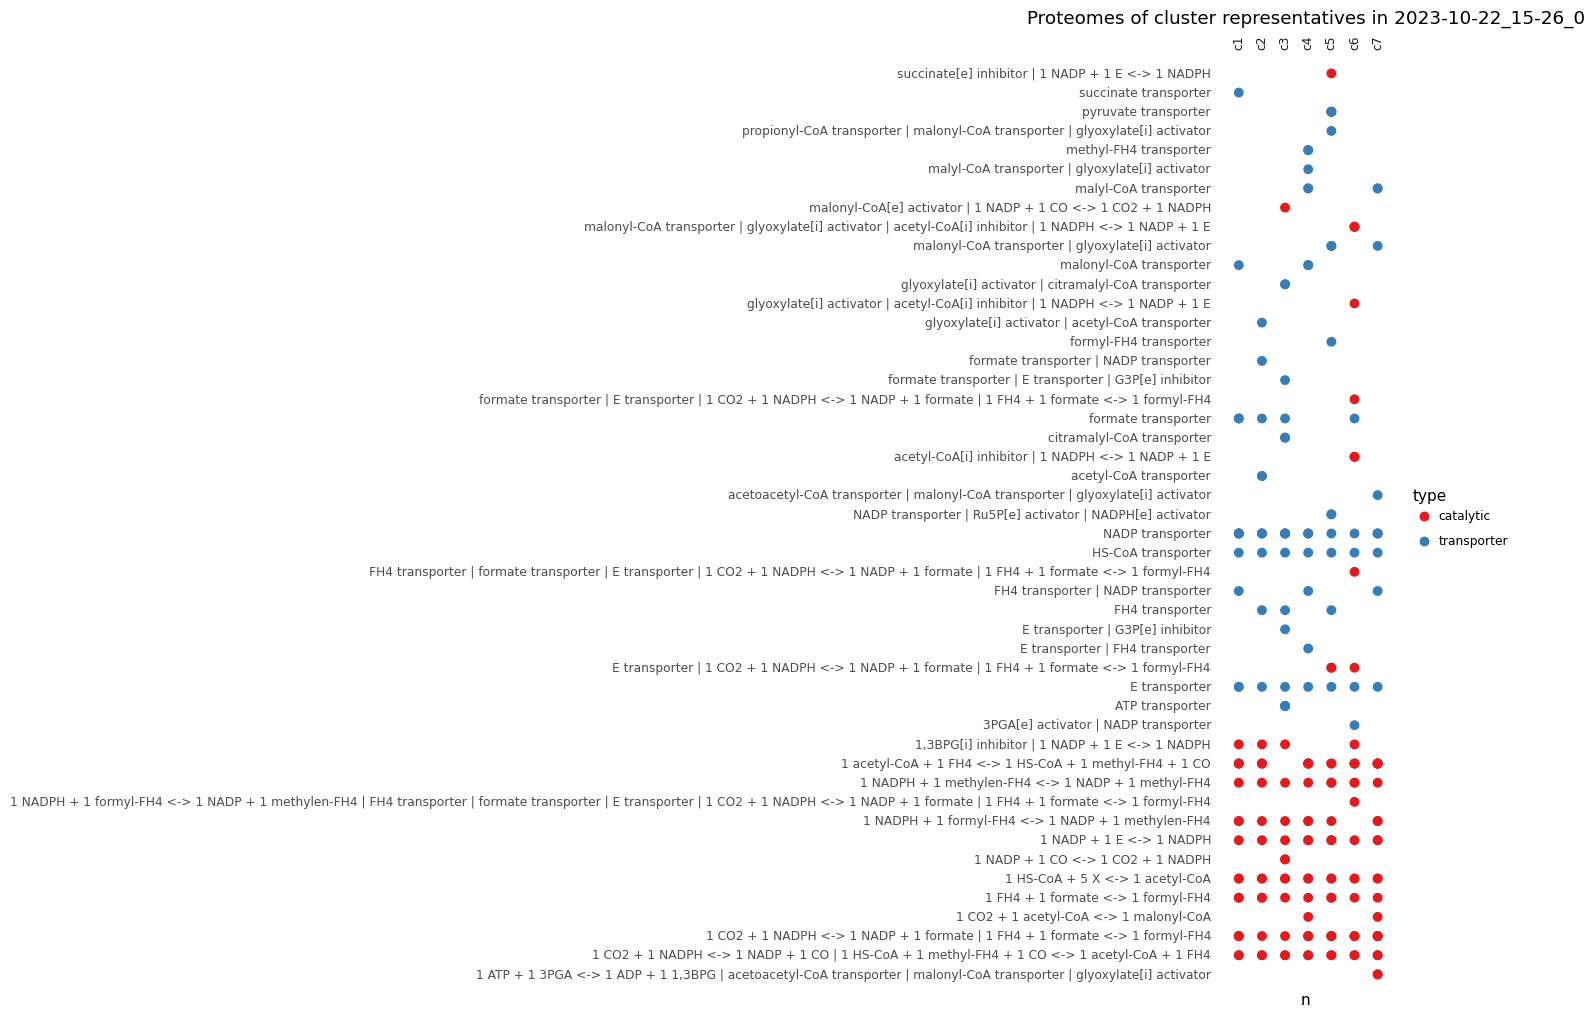

<ggplot: (8766088698745)>

In [38]:
df = get_proteomes_summary(world=world, clst_2_genome=clst_genome_map)
(ggplot(df)
    + geom_point(aes(x="protein", y="n", color="type"), size=3)
    + coord_flip()
    + facet_grid(". ~ cluster")
    + scale_color_brewer(type="Qualitative", palette="Set1")
    + ggtitle(f"Proteomes of cluster representatives in {name}")
    + theme(figure_size=(2, 12))
    + theme(strip_text_x=element_text(angle=90, margin={"b": 10}))
    + theme(axis_title_y=element_blank(), axis_text_x=element_blank())
    + theme(panel_grid_major=element_blank(), panel_grid_minor=element_blank()))

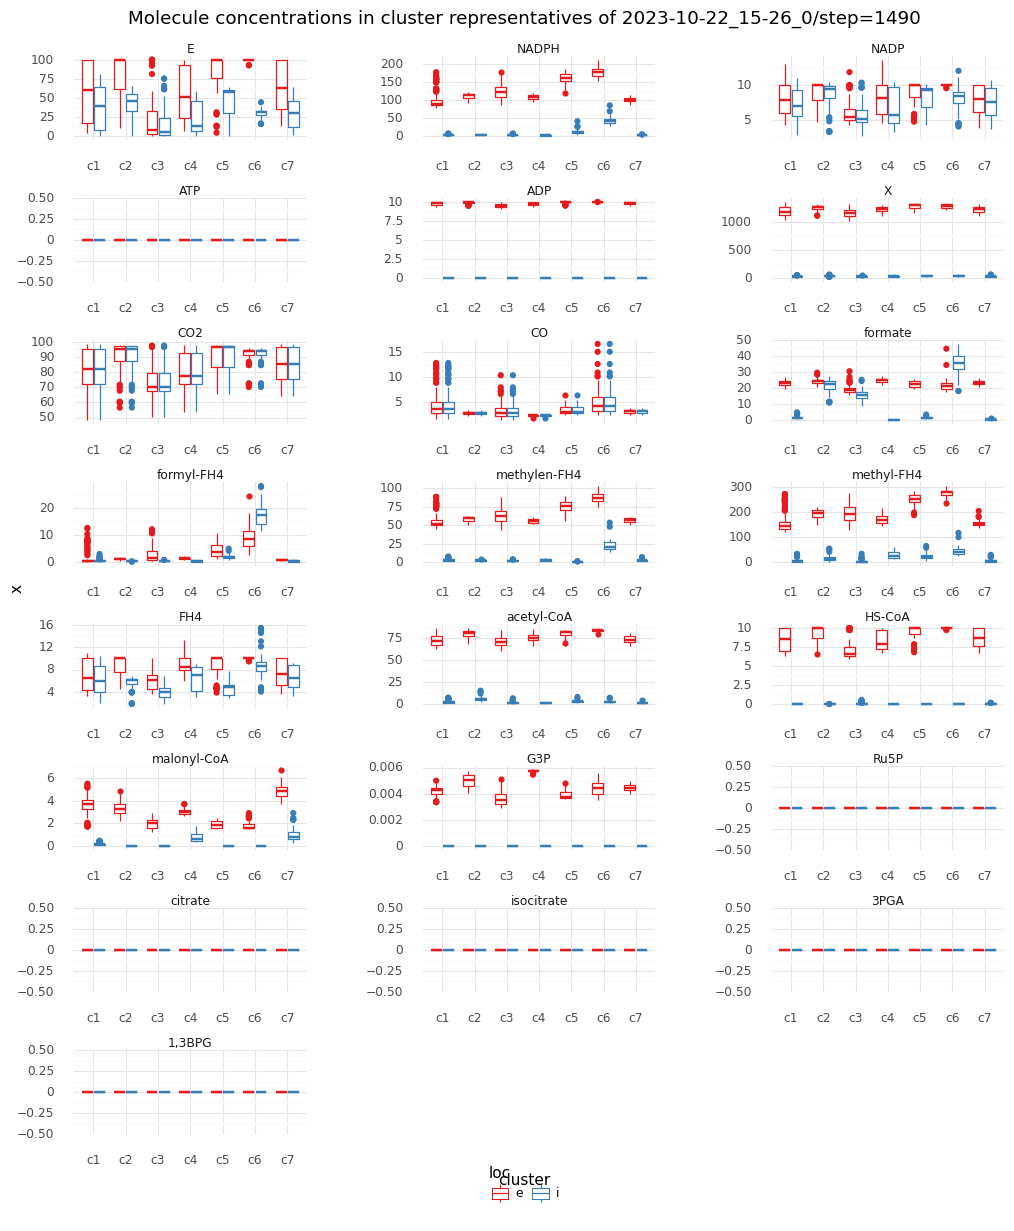

<ggplot: (8766130797635)>

In [40]:
df = get_mol_concentrations(
    cluster_2_genome=clst_genome_map,
    molnames=[
        "E", "NADPH", "NADP", "ATP", "ADP",
        "X", "CO2", "CO", "formate",
        "formyl-FH4", "methylen-FH4", "methyl-FH4", "FH4",
        "acetyl-CoA", "HS-CoA", "malonyl-CoA",
        "G3P", "Ru5P", "citrate", "isocitrate", "3PGA", "1,3BPG"
    ],
    world=world
)

(ggplot(df)
    + geom_boxplot(aes(x="cluster", y="x", color="loc"))
    + facet_wrap("mol", ncol=3, scales="free")
    + scale_color_brewer(type="Qualitative", palette="Set1")
    + ggtitle(f"Molecule concentrations in cluster representatives of {state_name}")
    + theme(legend_position="bottom")
    + theme(figure_size=(12, 14), subplots_adjust={'wspace': 0.5, 'hspace': 0.7}))

In [267]:
def get_coding_region_indexes(
    seq: str,
    min_cds_size: int,
    start_codons: list[str],
    stop_codons: list[str],
) -> list[tuple[int, int]]:
    s = ms.CODON_SIZE
    n = len(seq)
    max_start_idx = n - min_cds_size

    start_idxs = []
    for start_codon in start_codons:
        i = 0
        while i < max_start_idx:
            try:
                hit = seq[i:].index(start_codon)
                start_idxs.append(i + hit)
                i = i + hit + s
            except ValueError:
                break

    stop_idxs = []
    for stop_codon in stop_codons:
        i = 0
        while i < n - s:
            try:
                hit = seq[i:].index(stop_codon)
                stop_idxs.append(i + hit)
                i = i + hit + s
            except ValueError:
                break

    start_idxs.sort()
    stop_idxs.sort()

    by_frame: list[tuple[list[int], ...]] = [([], []), ([], []), ([], [])]
    for start_idx in start_idxs:
        if start_idx % 3 == 0:
            by_frame[0][0].append(start_idx)
        elif (start_idx + 1) % 3 == 0:
            by_frame[1][0].append(start_idx)
        else:
            by_frame[2][0].append(start_idx)
    for stop_idx in stop_idxs:
        if stop_idx % 3 == 0:
            by_frame[0][1].append(stop_idx)
        elif (stop_idx + 1) % 3 == 0:
            by_frame[1][1].append(stop_idx)
        else:
            by_frame[2][1].append(stop_idx)

    cdss = []
    for start_idxs, stop_idxs in by_frame:
        for start_idx in start_idxs:
            stop_idxs = [d for d in stop_idxs if d > start_idx + s]
            if len(stop_idxs) > 0:
                cds_end_idx = min(stop_idxs) + s
                if cds_end_idx - start_idx > min_cds_size:
                    cdss.append((start_idx, cds_end_idx))
            else:
                break

    return cdss

def extract_domains(
    seq: str,
    cdss_idxs: list[tuple[int, int]],
    dom_size: int,
    dom_type_size: int,
    dom_type_map: dict[str, int],
    one_codon_map: dict[str, int],
    two_codon_map: dict[str, int],
) -> tuple[list[tuple[int, int]], list[list[tuple[int, int, int, int, int]]]]:
    s = ms.CODON_SIZE
    idx0_slice = slice(0, s)
    idx1_slice = slice(s, 2 * s)
    idx2_slice = slice(2 * s, 3 * s)
    idx3_slice = slice(3 * s, 5 * s)

    prot_doms = []
    used_cds_idxs = []
    for cds_start, cds_stop in cdss_idxs:
        cds = seq[cds_start:cds_stop]
        doms = []
        is_useful_prot = False

        i = 0
        j = dom_size
        while i + dom_size <= len(cds):
            dom_type_seq = cds[i : i + dom_type_size]
            if dom_type_seq in dom_type_map:
                # 1=catal, 2=trnsp, 3=reg
                dom_type = dom_type_map[dom_type_seq]
                if dom_type != 3:
                    is_useful_prot = True

                dom_spec_seq = cds[i + dom_type_size : i + dom_size]
                idx0 = one_codon_map[dom_spec_seq[idx0_slice]]
                idx1 = one_codon_map[dom_spec_seq[idx1_slice]]
                idx2 = one_codon_map[dom_spec_seq[idx2_slice]]
                idx3 = two_codon_map[dom_spec_seq[idx3_slice]]
                doms.append((dom_type, idx0, idx1, idx2, idx3))
                i += dom_size
                j += dom_size
            else:
                i += s
                j += s

        # protein should have at least 1 non-regulatory domain
        if is_useful_prot:
            used_cds_idxs.append((cds_start, cds_stop))
            prot_doms.append(doms)

    return used_cds_idxs, prot_doms

def get_coordinates_protein_tuples(genome: str) -> list[tuple[str, tuple[int, int]]]:
    cdss_idxs = get_coding_region_indexes(
        seq=genome,
        min_cds_size=world.genetics.dom_size,
        start_codons=world.genetics.start_codons,
        stop_codons=world.genetics.stop_codons    
    )
    cdss_idxs, dom_specs = extract_domains(
        seq=genome,
        cdss_idxs=cdss_idxs,
        dom_size=world.genetics.dom_size,
        dom_type_size=len(next(iter(world.genetics.domain_map))),
        dom_type_map=world.genetics.domain_map,
        one_codon_map=world.genetics.one_codon_map,
        two_codon_map=world.genetics.two_codon_map,
    )
    
    if len(dom_specs) == 0:
        return []

    prots = world.kinetics.get_proteome(proteome=dom_specs)
    return [(str(p), i) for i, p in zip(cdss_idxs, prots) if p.n_domains > 0]

def viz_genome(fwd: str, title="", width=6, figsize=(14, 6)):
    n = len(fwd)
    cds_width = width
    genome_width = 0.66 * cds_width
    arrow_offset = 1.33 * cds_width
    arrow_width = 1.16 * cds_width
    
    records = []
    for prot, idxs in get_coordinates_protein_tuples(genome=fwd):
        records.append({"direction": "fwd", "start": idxs[0], "stop": idxs[1], "domains": prot})
    bwd = ms.reverse_complement(seq=fwd)
    for prot, idxs in get_coordinates_protein_tuples(genome=bwd):
        records.append({"direction": "bwd", "start": n - idxs[1], "stop": n - idxs[0], "domains": prot})
    
    df = pd.DataFrame.from_records(records)
    df["tag"] = [f"P{d}" for d in range(len(df))]
    df["type"] = "transporter"
    df.loc[df["domains"].str.contains("<->"), "type"] = "catalytic"
    is_fwd = df["direction"] == "fwd"
    is_bwd = df["direction"] == "bwd"
    
    df["textpos"] = (df["start"] + df["stop"]) / 2
    df.loc[is_fwd, "textpos"] = (df.loc[is_fwd, "textpos"] - arrow_offset).clip(lower=df.loc[is_fwd, "start"] + 10)
    df.loc[is_bwd, "textpos"] = (df.loc[is_bwd, "textpos"] + arrow_offset).clip(upper=df.loc[is_bwd, "stop"] - 10)
    
    fwd_tags = df.loc[is_fwd, "tag"].unique().tolist()
    bwd_tags = df.loc[is_bwd, "tag"].unique().tolist()
    cats = list(reversed(fwd_tags + ["genome"] + bwd_tags))

    genome = pd.DataFrame({"tag": ["genome"], "start": [0], "stop": [n]})
    points = df[["direction", "start", "stop", "tag", "type"]].copy()

    df.loc[df["direction"] == "fwd", "stop"] -= arrow_offset
    df.loc[df["direction"] == "bwd", "start"] += arrow_offset

    df["tag"] = pd.Categorical(df["tag"], categories=cats, ordered=True)
    genome["tag"] = pd.Categorical(genome["tag"], categories=cats, ordered=True)
    points["tag"] = pd.Categorical(points["tag"], categories=cats, ordered=True)

    print(df[["tag", "domains"]].to_string())

    return (ggplot(df)
        + geom_segment(aes(x="start", y="tag", xend="stop", yend="tag"), size=genome_width, color="darkgrey", data=genome)
        + geom_segment(aes(x="start", y="tag", xend="stop", yend="tag", color="type"), size=cds_width, data=df[df["direction"] == "fwd"])
        + geom_segment(aes(x="start", y="tag", xend="stop", yend="tag", color="type"), size=cds_width, data=df[df["direction"] == "bwd"])
        + geom_text(aes(x="textpos", y="tag", label="tag"), color="white", size=10)
        + geom_point(aes(x="stop", y="tag", color="type"), data=points[points["direction"] == "fwd"], shape=5, size=arrow_width)
        + geom_point(aes(x="start", y="tag", color="type"), data=points[points["direction"] == "bwd"], shape=4, size=arrow_width)
        + theme(figure_size=figsize)
        + scale_color_brewer(type="Qualitative", palette="Set1")
        + theme(panel_grid_major=element_blank(), panel_grid_minor=element_blank())
        + ggtitle(title))

    tag                                                                                      domains
0    P0  1 CO2 + 1 NADPH <-> 1 NADP + 1 CO | 1 HS-CoA + 1 methyl-FH4 + 1 CO <-> 1 acetyl-CoA + 1 FH4
1    P1  1 CO2 + 1 NADPH <-> 1 NADP + 1 CO | 1 HS-CoA + 1 methyl-FH4 + 1 CO <-> 1 acetyl-CoA + 1 FH4
2    P2                                                           FH4 transporter | NADP transporter
3    P3                                                                             NADP transporter
4    P4                                                                             NADP transporter
5    P5                                                                             NADP transporter
6    P6                                                                                E transporter
7    P7                                                                                E transporter
8    P8                                               1,3BPG[i] inhibitor | 1 NADP + 1 E <-

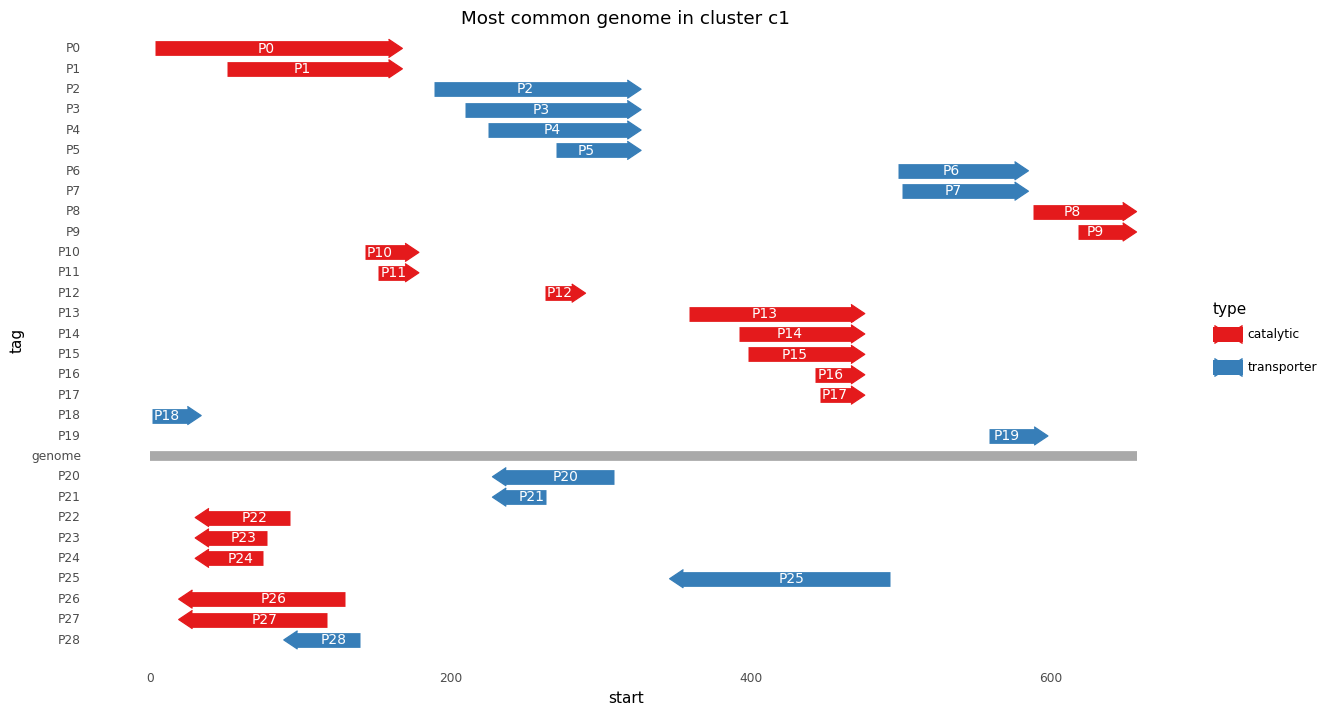

<ggplot: (8766169903834)>

In [268]:
clst = "c1"
viz_genome(world.genomes[int(clst_genome_map[clst][1:])], title=f"Most common genome in cluster {clst}", figsize=(14, 8))

    tag                                                                                                                domains
0    P0                                                                                     FH4 transporter | NADP transporter
1    P1                                                                                                       NADP transporter
2    P2                                                                                                       NADP transporter
3    P3                                                                                                       NADP transporter
4    P4                                                                                                     HS-CoA transporter
5    P5                                                                     1 NADPH + 1 formyl-FH4 <-> 1 NADP + 1 methylen-FH4
6    P6                                                                     1 NADPH + 1 formyl-FH4 <-> 1 NADP +

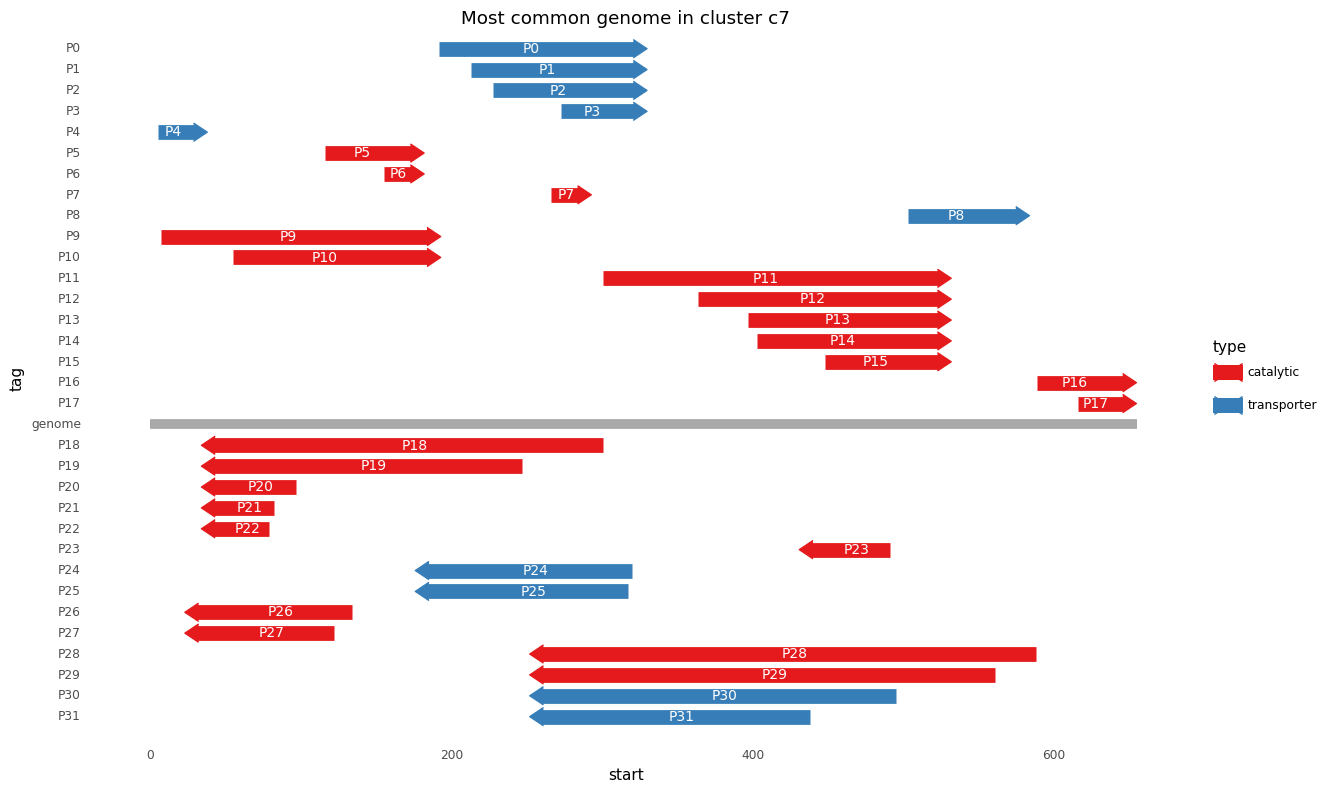

<ggplot: (8766169331716)>

In [269]:
clst = "c7"
viz_genome(world.genomes[int(clst_genome_map[clst][1:])], title=f"Most common genome in cluster {clst}", figsize=(14, 9), width=6)